# Football AI

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/sports)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/camera-calibration-sports-computer-vision/)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://www.youtube.com/watch?v=aBVGKoNZQUw)

Let's build a Football AI system to dig deeper into match stats! We'll use computer vision and machine learning to track players, determine which team is which, and even calculate stuff like ball possession and speed. This tutorial is perfect if you want to get hands-on with sports analytics and see how AI can take your football analysis to the next level.

![football AI diagram](https://media.roboflow.com/notebooks/examples/football-ai-diagram.png)

## Before you start

### Configure your API keys

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Install dependencjes

**Note:** Let's install the `inference-gpu` library, which will be used to efficiently run our object detection and keypoint detection models on GPUs.

In [ ]:
!pip install -q gdown inference-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.2 MB/s eta 0:00:

**Note:** Let's install the sports repository directly from GitHub. The sports repository contains a variety of football-related utilities that we'll use along the way.

In [3]:
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done


**Note:** Let's make sure we have the latest features in the supervision library by installing version `0.23.0` or higher.

In [4]:
!pip list | grep supervision

supervision                           0.25.1


**Note:** Let's download a few sample videos from the [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout) Kaggle competition using gdown.



In [ ]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 42.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /content/08fd33_0.mp4
100% 19.9M/19.9M [00:00<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /content/573e61_0.mp4
100% 18.9M/18.9M [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 112MB/s] 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## ball, player, goalkeeper and referee detection

In [6]:
! pip install ultralytics

In [51]:
from inference import get_model
from google.colab import userdata
from ultralytics import YOLO

PLAYER_DETECTION_MODEL = YOLO("/content/drive/MyDrive/TestTesi/video/football-players-detection.pt")


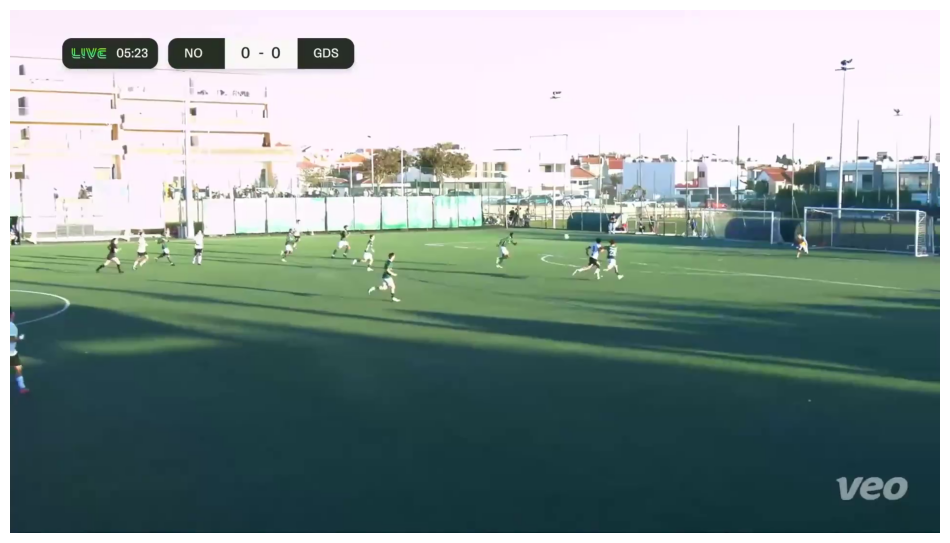

In [52]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)


0: 736x1280 11 players, 1 referee, 2577.9ms
Speed: 6.1ms preprocess, 2577.9ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)


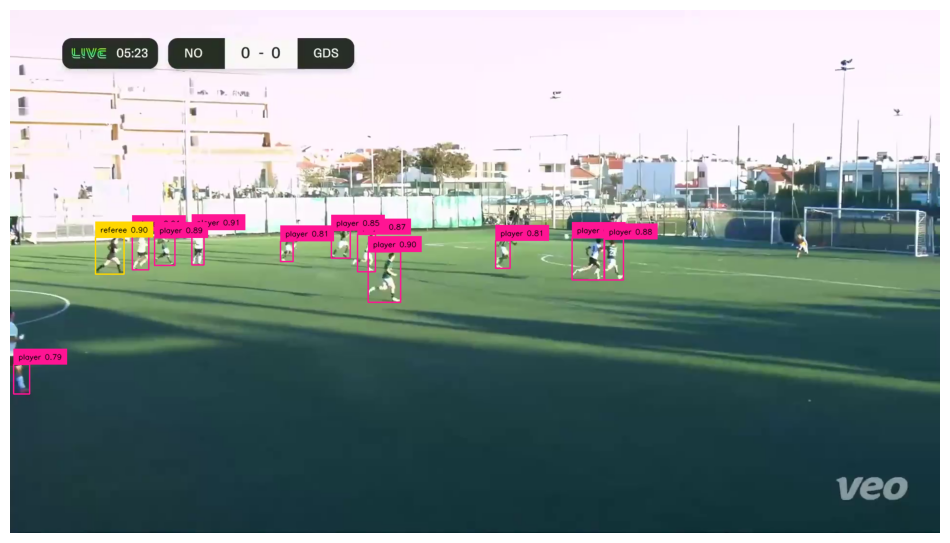

In [53]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.7)[0]
detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

## video game style visualization


0: 736x1280 11 players, 1 referee, 2215.7ms
Speed: 6.3ms preprocess, 2215.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


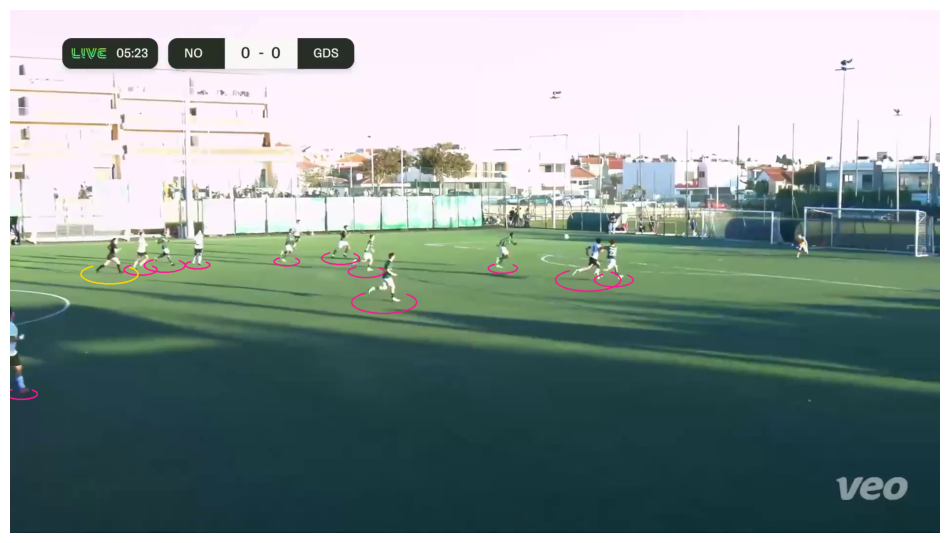

In [68]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.7)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## player tracking


0: 736x1280 10 players, 1 referee, 3317.4ms
Speed: 11.8ms preprocess, 3317.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


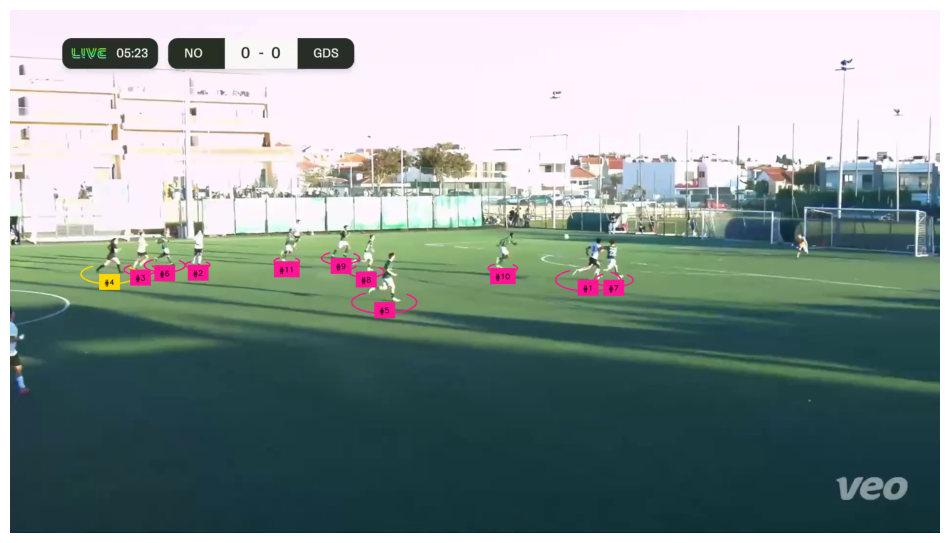

In [57]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.8)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.1, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## split players into teams

![football AI diagram](https://media.roboflow.com/notebooks/examples/football-ai-team-clustering.png)

**Note:** Before training our player clustering model, we need to gather training data. To do this, we'll sample one frame per second, detect players within those frames, and then crop them out.

In [85]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.7)[0]
    detections = sv.Detections.from_ultralytics(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 11 players, 1 referee, 3019.5ms
Speed: 11.3ms preprocess, 3019.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:03,  3.07s/it]


0: 736x1280 1 goalkeeper, 11 players, 1 referee, 2556.0ms
Speed: 6.2ms preprocess, 2556.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:05,  2.80s/it]


0: 736x1280 8 players, 2515.5ms
Speed: 6.3ms preprocess, 2515.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:08,  2.70s/it]


0: 736x1280 10 players, 2 referees, 2535.8ms
Speed: 8.1ms preprocess, 2535.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:10,  2.66s/it]


0: 736x1280 11 players, 1 referee, 2518.9ms
Speed: 9.4ms preprocess, 2518.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:13,  2.63s/it]


0: 736x1280 10 players, 1 referee, 2499.1ms
Speed: 6.5ms preprocess, 2499.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:16,  2.61s/it]


0: 736x1280 8 players, 1 referee, 2571.5ms
Speed: 5.3ms preprocess, 2571.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:18,  2.61s/it]


0: 736x1280 10 players, 2457.8ms
Speed: 6.3ms preprocess, 2457.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:21,  2.58s/it]


0: 736x1280 1 goalkeeper, 9 players, 1 referee, 2643.8ms
Speed: 6.1ms preprocess, 2643.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:23,  2.62s/it]


0: 736x1280 3 players, 1 referee, 2828.6ms
Speed: 5.1ms preprocess, 2828.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:26,  2.70s/it]


0: 736x1280 7 players, 3 referees, 3738.3ms
Speed: 6.7ms preprocess, 3738.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:30,  3.04s/it]


0: 736x1280 6 players, 2 referees, 2533.7ms
Speed: 6.8ms preprocess, 2533.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:33,  2.91s/it]


0: 736x1280 10 players, 1 referee, 2506.5ms
Speed: 20.4ms preprocess, 2506.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:35,  2.81s/it]


0: 736x1280 11 players, 1 referee, 2580.6ms
Speed: 6.5ms preprocess, 2580.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:38,  2.76s/it]


0: 736x1280 9 players, 1 referee, 2456.1ms
Speed: 6.0ms preprocess, 2456.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:40,  2.69s/it]


0: 736x1280 1 goalkeeper, 8 players, 1 referee, 2611.3ms
Speed: 6.4ms preprocess, 2611.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:43,  2.73s/it]


**Note:** Here's a sample (100 elements) of the crops we've gathered.

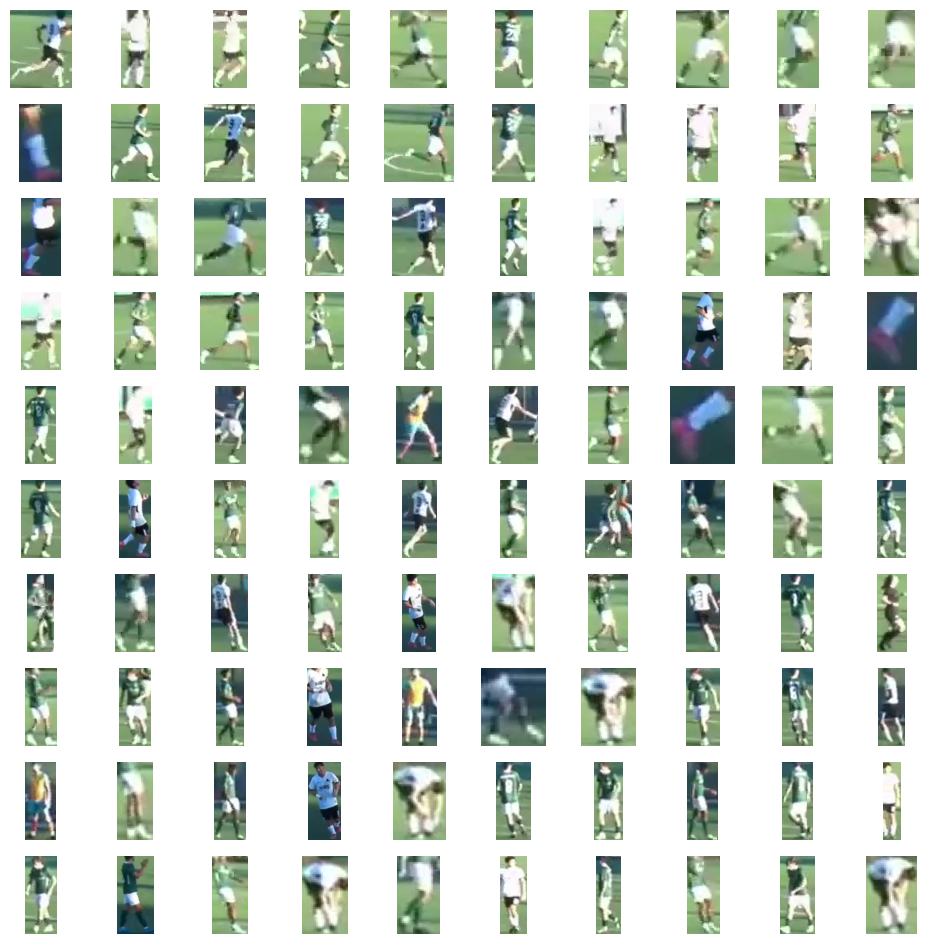

In [86]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

**Note:** Next, we'll run [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) to calculate embeddings for each of the crops.

In [87]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [88]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 5it [00:25,  5.01s/it]


**Note:** Using [UMAP](https://github.com/lmcinnes/umap), we project our embeddings from `(N, 768)` to `(N, 3)` and then perform a two-cluster division using [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [89]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [90]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



**Note:** Here's an interactive visualization of our results. Click on a dot to display its associated crop.


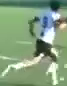
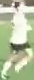
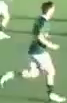
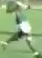
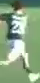
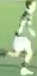
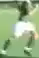
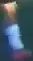
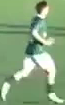
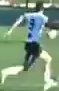
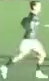
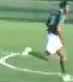
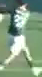
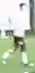
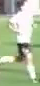
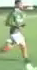
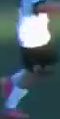
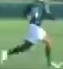
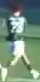
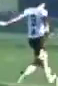
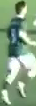
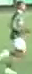
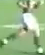
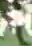
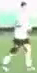
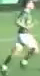
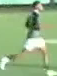
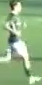
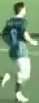
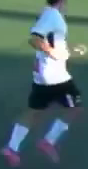
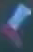
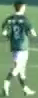
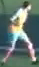
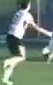
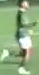
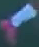
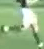
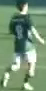
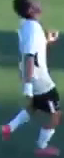
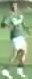
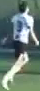
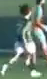
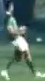
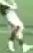
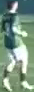
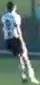
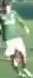
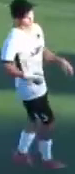
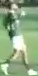
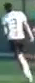
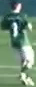
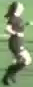
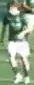
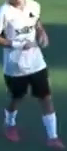
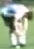
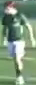
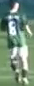
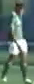
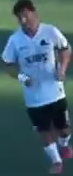
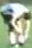
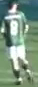
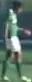
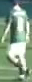
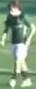
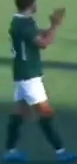
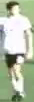
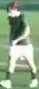
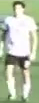
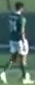
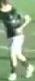
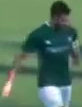
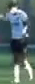
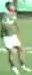
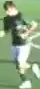
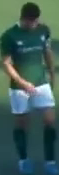
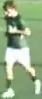
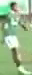
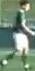
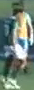
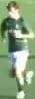
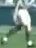
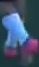

In [91]:
import plotly.graph_objects as go
import numpy as np
from typing import Dict, List
from IPython.core.display import display, HTML
from PIL import Image
import base64
from io import BytesIO


def pil_image_to_data_uri(image: Image.Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"


def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    images: List[Image.Image],
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    image_data_uris = {f"image_{i}": pil_image_to_data_uri(image) for i, image in enumerate(images)}
    image_ids = np.array([f"image_{i}" for i in range(len(images))])

    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_ids[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="<b>class: %{text}</b><br>image ID: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    # Calculate shared range for cube appearance
    all_axes = projections
    min_val = np.min(all_axes)
    max_val = np.max(all_axes)
    padding = (max_val - min_val) * 0.05
    axis_range = [min_val - padding, max_val + padding]

    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', range=axis_range),
            yaxis=dict(title='Y', range=axis_range),
            zaxis=dict(title='Z', range=axis_range),
            aspectmode='cube'  # Ensures equal scaling
        ),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-3d")

    javascript_code = f"""
    <script>
        function displayImage(imageId) {{
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            var imageDataURIs = {image_data_uris};
            imageElement.src = imageDataURIs[imageId];
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        var chartElement = document.getElementById('scatter-plot-3d');

        chartElement.on('plotly_click', function(data) {{
            var customdata = data.points[0].customdata;
            displayImage(customdata);
        }});
    </script>
    """

    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 5px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """

    display(HTML(html_template))

display_projections(clusters, projections, crops)

**Note:** To simplify the use of the SigLIP, UMAP, and KMeans combo, I've packaged all these models into a [`TeamClassifier`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/common/team.py#L41) that you can find in the [sports](https://github.com/roboflow/sports) repository.

In [92]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier()
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 2 balls, 1 goalkeeper, 15 players, 1 referee, 2969.5ms
Speed: 6.9ms preprocess, 2969.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:03,  3.03s/it]


0: 736x1280 2 balls, 1 goalkeeper, 16 players, 1 referee, 2572.8ms
Speed: 6.4ms preprocess, 2572.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:05,  2.79s/it]


0: 736x1280 1 ball, 18 players, 2676.0ms
Speed: 7.5ms preprocess, 2676.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:08,  2.77s/it]


0: 736x1280 1 ball, 13 players, 2 referees, 2407.5ms
Speed: 7.7ms preprocess, 2407.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:10,  2.65s/it]


0: 736x1280 1 ball, 17 players, 1 referee, 2487.2ms
Speed: 7.5ms preprocess, 2487.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:13,  2.62s/it]


0: 736x1280 14 players, 1 referee, 2570.8ms
Speed: 7.0ms preprocess, 2570.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:16,  2.62s/it]


0: 736x1280 9 players, 2 referees, 2637.3ms
Speed: 6.0ms preprocess, 2637.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:18,  2.65s/it]


0: 736x1280 11 players, 1 referee, 2463.4ms
Speed: 7.6ms preprocess, 2463.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:21,  2.61s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2482.1ms
Speed: 5.4ms preprocess, 2482.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:23,  2.58s/it]


0: 736x1280 9 players, 4 referees, 2435.0ms
Speed: 7.0ms preprocess, 2435.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:26,  2.56s/it]


0: 736x1280 10 players, 4 referees, 2479.5ms
Speed: 5.9ms preprocess, 2479.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:28,  2.55s/it]


0: 736x1280 9 players, 3 referees, 2480.6ms
Speed: 4.8ms preprocess, 2480.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:31,  2.55s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2445.5ms
Speed: 8.8ms preprocess, 2445.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:33,  2.54s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2528.8ms
Speed: 7.2ms preprocess, 2528.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:36,  2.56s/it]


0: 736x1280 12 players, 1 referee, 2630.6ms
Speed: 9.3ms preprocess, 2630.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:39,  2.60s/it]


0: 736x1280 1 goalkeeper, 13 players, 2 referees, 2665.7ms
Speed: 5.9ms preprocess, 2665.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:41,  2.62s/it]
Embedding extraction: 8it [00:45,  5.64s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



**Note:** Time to assign goalkeepers to teams. We'll use a simple heuristic: calculate the average position (centroid) of the players belonging to both teams and then assign the goalkeeper to the team whose average position is closer.

In [93]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)


0: 736x1280 2 balls, 1 goalkeeper, 15 players, 1 referee, 2448.8ms
Speed: 7.0ms preprocess, 2448.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:02,  2.42s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



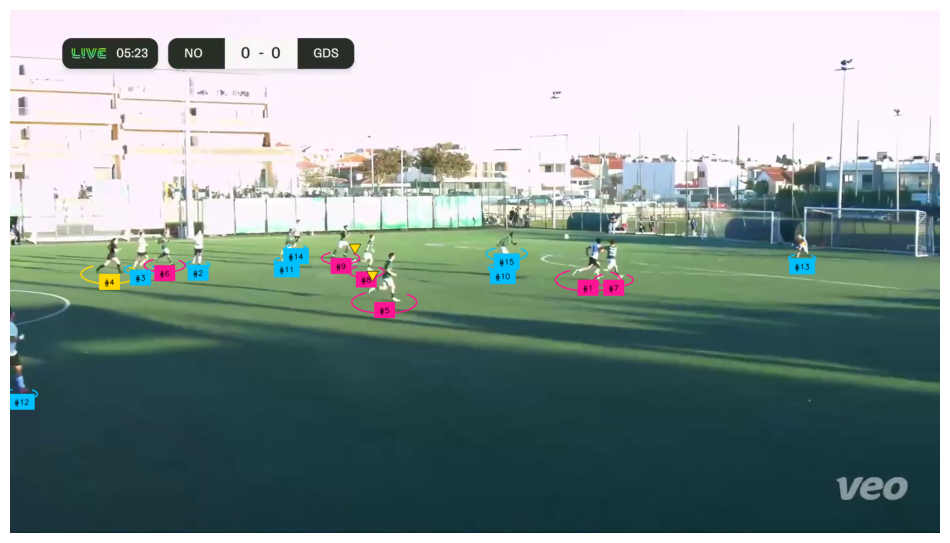

In [94]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## pitch keypoint detection

In [95]:
from inference import get_model
from google.colab import userdata

FIELD_DETECTION_MODEL= YOLO("/content/drive/MyDrive/TestTesi/mine /football-pitch-detection.pt")



0: 384x640 1 pitch, 846.1ms
Speed: 3.2ms preprocess, 846.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


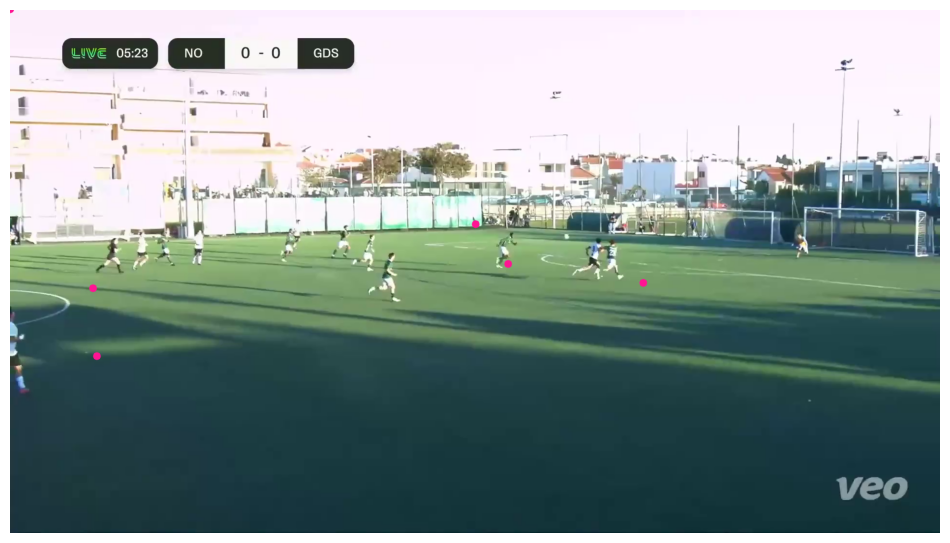

In [100]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.predict(frame, conf=0.85)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

**Note:** Notice that some of the keypoints we detected are in incorrect locations. These are keypoints with a low confidence level. Let's filter out these keypoints and keep only the ones the model is confident about.

## filter low confidence keypoints


0: 384x640 2 pitchs, 840.3ms
Speed: 3.0ms preprocess, 840.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


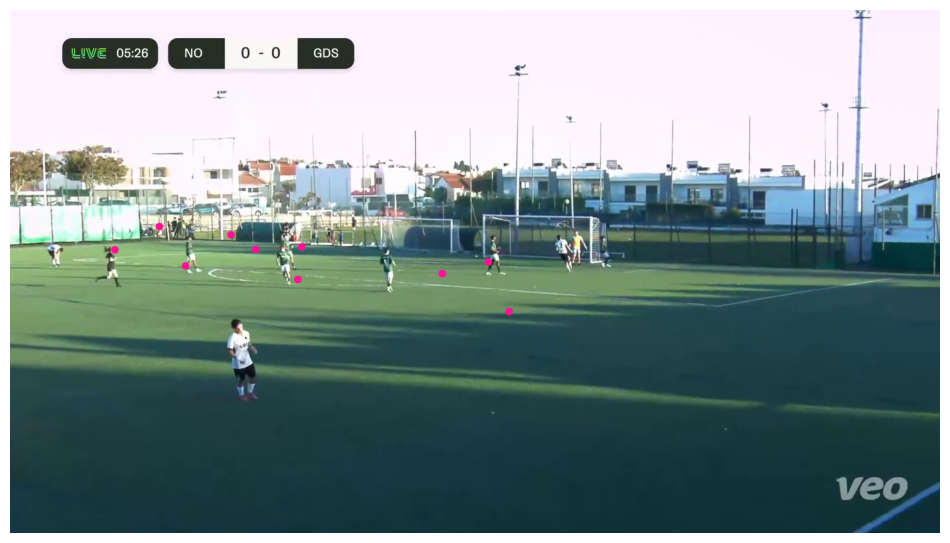

In [102]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.predict(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

## project pitch lines on frame

**Note:** The [sports](https://github.com/roboflow/sports) repository contains a [`SoccerPitchConfiguration`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/configs/soccer.py#L6) that provides information about the real-world geometry of the soccer pitch. It also includes utilities for visualizing elements located on the pitch.

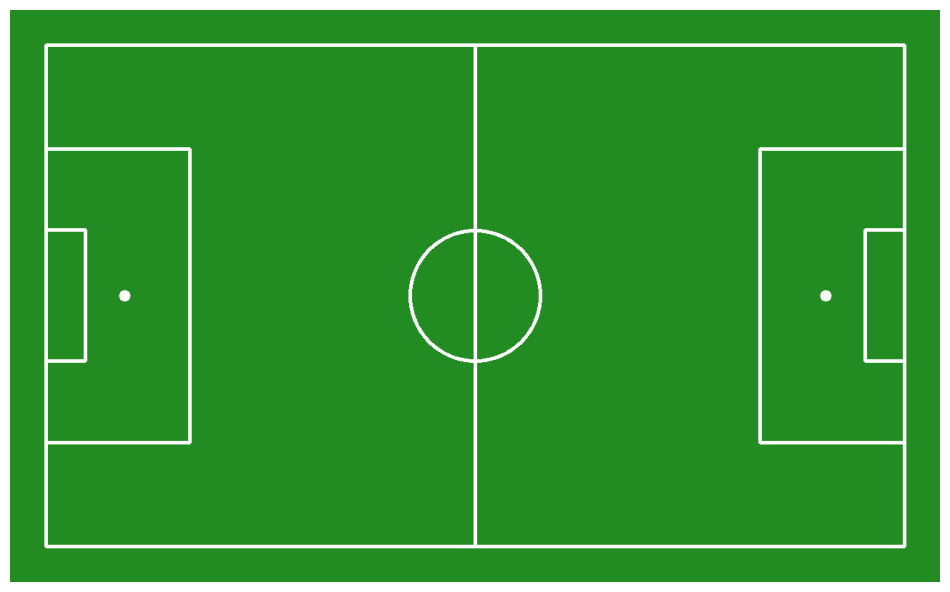

In [103]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

**Note:** It's time to utilize the keypoint pairs located on the camera perspective plane and the football pitch plane. The [sports](https://github.com/roboflow/sports) repository includes a [`ViewTransformer`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/common/view.py#L7), which employs homography for perspective transformation.


0: 384x640 2 pitchs, 1096.2ms
Speed: 27.2ms preprocess, 1096.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


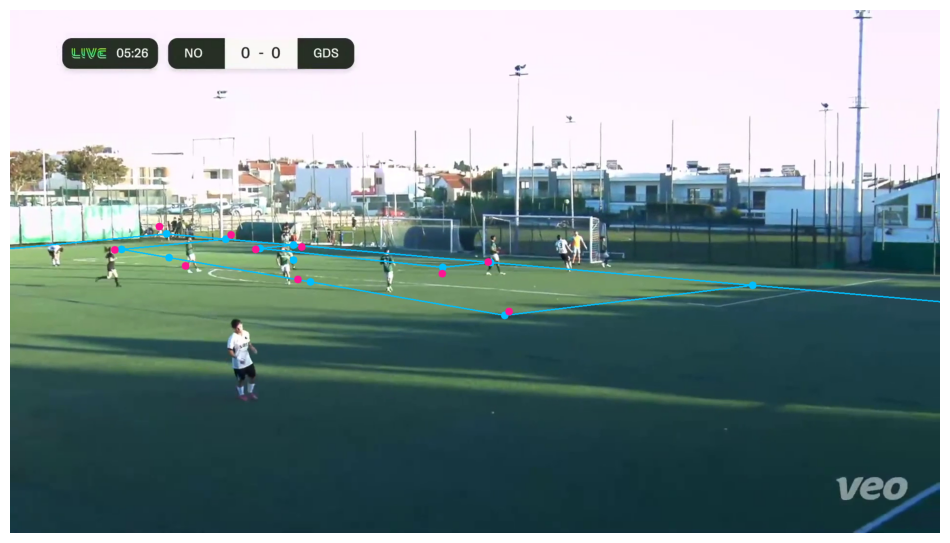

In [105]:
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.predict(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

## project ball, players and referies on pitch

In [109]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier()
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 2 balls, 1 goalkeeper, 15 players, 1 referee, 3748.9ms
Speed: 14.6ms preprocess, 3748.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:03,  3.81s/it]


0: 736x1280 2 balls, 1 goalkeeper, 16 players, 1 referee, 2781.1ms
Speed: 8.6ms preprocess, 2781.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:06,  3.24s/it]


0: 736x1280 1 ball, 18 players, 3238.4ms
Speed: 20.7ms preprocess, 3238.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:09,  3.28s/it]


0: 736x1280 1 ball, 13 players, 2 referees, 2411.6ms
Speed: 10.8ms preprocess, 2411.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:12,  2.96s/it]


0: 736x1280 1 ball, 17 players, 1 referee, 2421.6ms
Speed: 7.2ms preprocess, 2421.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:14,  2.79s/it]


0: 736x1280 14 players, 1 referee, 2378.5ms
Speed: 9.9ms preprocess, 2378.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:17,  2.67s/it]


0: 736x1280 9 players, 2 referees, 2442.0ms
Speed: 5.2ms preprocess, 2442.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:19,  2.62s/it]


0: 736x1280 11 players, 1 referee, 2435.4ms
Speed: 6.1ms preprocess, 2435.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:22,  2.58s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2412.6ms
Speed: 14.3ms preprocess, 2412.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:24,  2.55s/it]


0: 736x1280 9 players, 4 referees, 3666.1ms
Speed: 5.4ms preprocess, 3666.1ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:28,  2.91s/it]


0: 736x1280 10 players, 4 referees, 2503.2ms
Speed: 22.5ms preprocess, 2503.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:31,  2.82s/it]


0: 736x1280 9 players, 3 referees, 2605.3ms
Speed: 7.0ms preprocess, 2605.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:33,  2.77s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2521.0ms
Speed: 7.4ms preprocess, 2521.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:36,  2.72s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2690.6ms
Speed: 12.8ms preprocess, 2690.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:39,  2.73s/it]


0: 736x1280 12 players, 1 referee, 2358.7ms
Speed: 6.0ms preprocess, 2358.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:41,  2.64s/it]


0: 736x1280 1 goalkeeper, 13 players, 2 referees, 2326.8ms
Speed: 5.9ms preprocess, 2326.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:44,  2.75s/it]
Embedding extraction: 8it [00:42,  5.37s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [110]:
import cv2
from typing import Optional

def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay


0: 736x1280 2 balls, 1 goalkeeper, 15 players, 1 referee, 3698.1ms
Speed: 5.3ms preprocess, 3698.1ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:02,  2.72s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



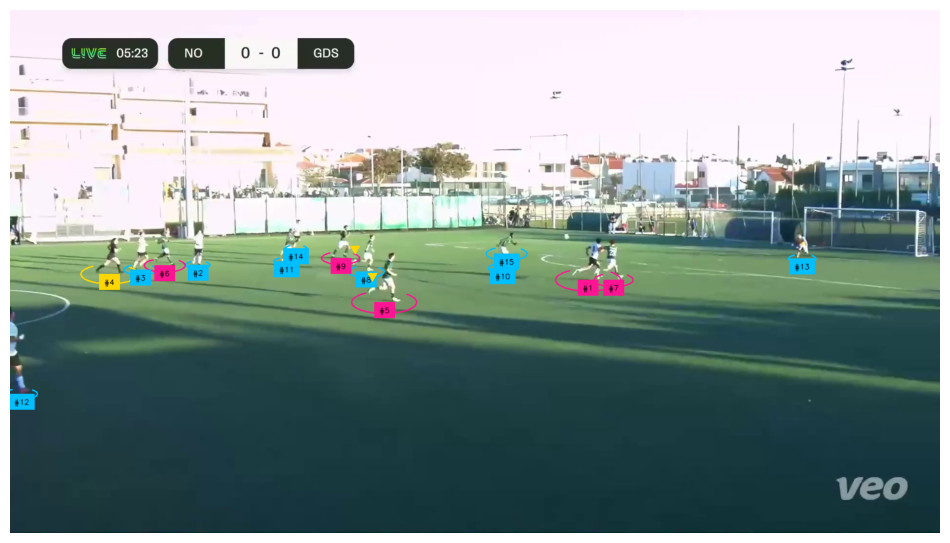


0: 384x640 2 pitchs, 792.8ms
Speed: 12.4ms preprocess, 792.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


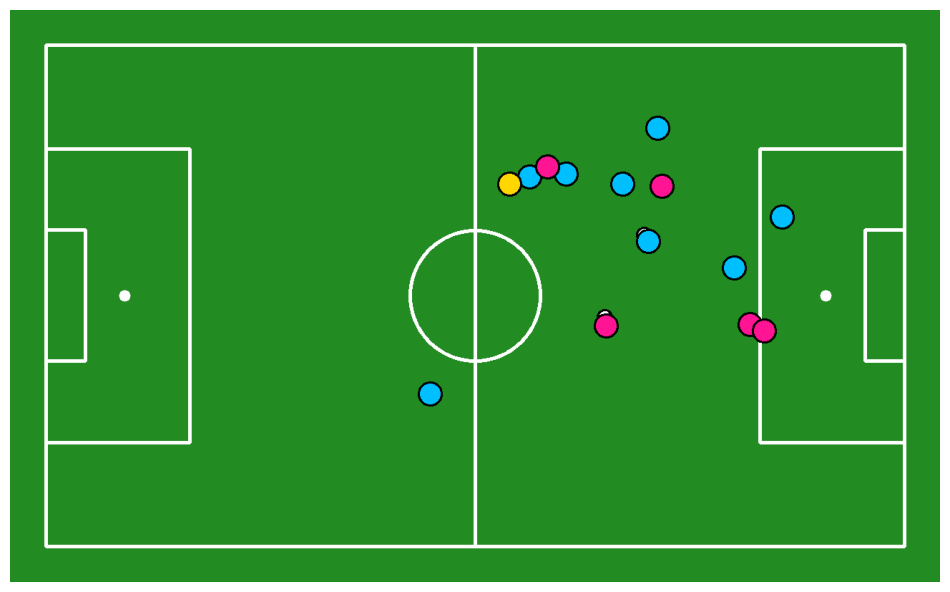

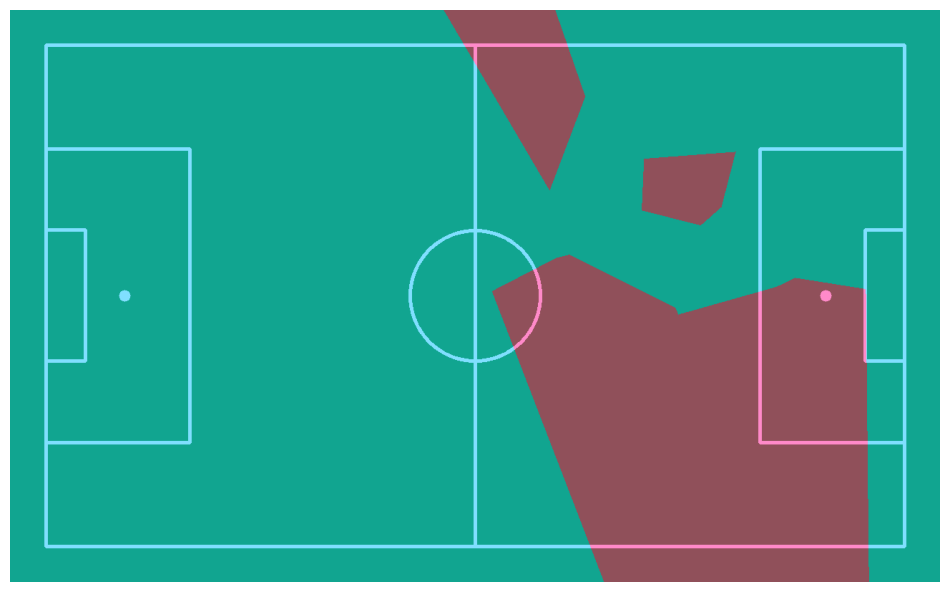

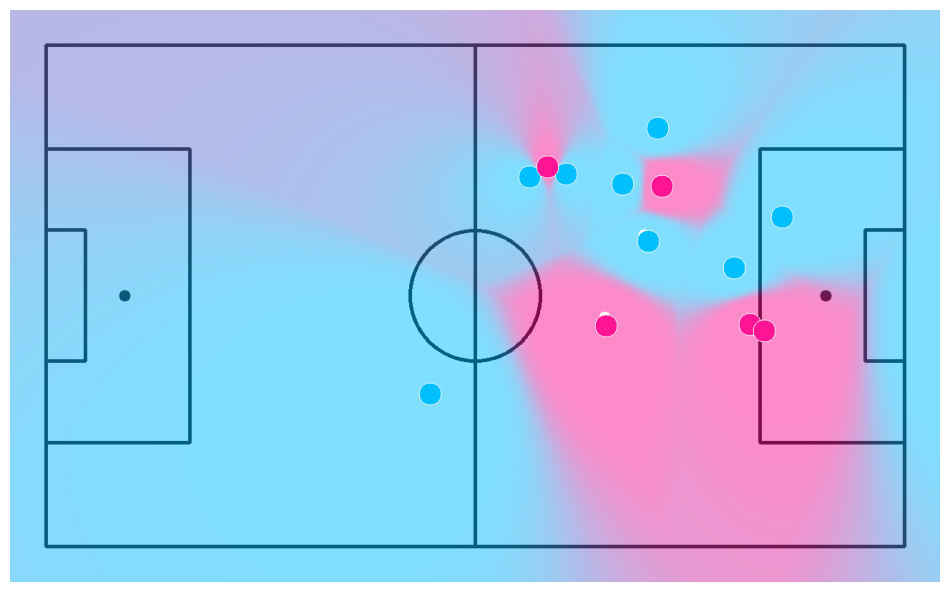

In [113]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points

result = FIELD_DETECTION_MODEL.predict(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# visualize video game-style radar view

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram with blend

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

## ball tracking

In [117]:
from collections import deque
import supervision as sv
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/TestTesi/TESTVIDEO copy.mp4"
BALL_ID = 0
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):

    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = FIELD_DETECTION_MODEL.predict(frame, conf=0.3)[0]
    key_points = sv.KeyPoints.from_ultralytics(result)

    filter = key_points.confidence[0] > 0.2
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    path_raw.append(pitch_ball_xy)

  0%|          | 0/466 [00:00<?, ?it/s]


0: 736x1280 2 balls, 1 goalkeeper, 15 players, 1 referee, 2657.1ms
Speed: 13.9ms preprocess, 2657.1ms inference, 11.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 873.3ms
Speed: 5.8ms preprocess, 873.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 1/466 [00:03<28:01,  3.62s/it]


0: 736x1280 2 balls, 16 players, 1 referee, 3432.8ms
Speed: 5.9ms preprocess, 3432.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 735.2ms
Speed: 3.1ms preprocess, 735.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 2/466 [00:07<30:36,  3.96s/it]


0: 736x1280 2 balls, 17 players, 1 referee, 2471.6ms
Speed: 9.0ms preprocess, 2471.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 769.1ms
Speed: 2.8ms preprocess, 769.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 3/466 [00:11<28:07,  3.65s/it]


0: 736x1280 2 balls, 14 players, 1 referee, 2323.4ms
Speed: 6.3ms preprocess, 2323.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 696.6ms
Speed: 2.3ms preprocess, 696.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 4/466 [00:14<26:14,  3.41s/it]


0: 736x1280 1 ball, 13 players, 1 referee, 2380.1ms
Speed: 5.0ms preprocess, 2380.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 731.7ms
Speed: 2.9ms preprocess, 731.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 5/466 [00:17<25:25,  3.31s/it]


0: 736x1280 1 ball, 13 players, 1 referee, 2419.4ms
Speed: 5.0ms preprocess, 2419.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 703.9ms
Speed: 2.1ms preprocess, 703.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  1%|▏         | 6/466 [00:20<24:56,  3.25s/it]


0: 736x1280 1 ball, 13 players, 1 referee, 2341.3ms
Speed: 5.1ms preprocess, 2341.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 779.2ms
Speed: 2.7ms preprocess, 779.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 7/466 [00:23<24:37,  3.22s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2396.9ms
Speed: 6.0ms preprocess, 2396.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 871.7ms
Speed: 1.9ms preprocess, 871.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 8/466 [00:26<24:45,  3.24s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2515.2ms
Speed: 7.0ms preprocess, 2515.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 780.9ms
Speed: 2.1ms preprocess, 780.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 9/466 [00:30<24:52,  3.27s/it]


0: 736x1280 1 ball, 1 goalkeeper, 15 players, 1 referee, 2420.3ms
Speed: 15.3ms preprocess, 2420.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 719.7ms
Speed: 1.9ms preprocess, 719.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 10/466 [00:33<24:36,  3.24s/it]


0: 736x1280 1 ball, 1 goalkeeper, 17 players, 1 referee, 2442.6ms
Speed: 5.8ms preprocess, 2442.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 752.9ms
Speed: 2.1ms preprocess, 752.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 11/466 [00:36<24:30,  3.23s/it]


0: 736x1280 1 ball, 15 players, 1 referee, 2473.0ms
Speed: 7.1ms preprocess, 2473.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 783.6ms
Speed: 2.4ms preprocess, 783.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 12/466 [00:39<24:34,  3.25s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 2488.0ms
Speed: 6.4ms preprocess, 2488.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 755.0ms
Speed: 2.9ms preprocess, 755.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 13/466 [00:43<24:34,  3.25s/it]


0: 736x1280 1 ball, 17 players, 1 referee, 2353.6ms
Speed: 6.1ms preprocess, 2353.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 719.2ms
Speed: 2.3ms preprocess, 719.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 14/466 [00:46<24:09,  3.21s/it]


0: 736x1280 1 ball, 16 players, 1 referee, 2384.7ms
Speed: 5.7ms preprocess, 2384.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 724.7ms
Speed: 2.1ms preprocess, 724.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 15/466 [00:49<23:56,  3.18s/it]


0: 736x1280 1 ball, 1 goalkeeper, 15 players, 1 referee, 2356.0ms
Speed: 5.0ms preprocess, 2356.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 783.6ms
Speed: 2.1ms preprocess, 783.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 16/466 [00:52<23:49,  3.18s/it]


0: 736x1280 1 ball, 1 goalkeeper, 15 players, 1 referee, 2407.0ms
Speed: 5.7ms preprocess, 2407.0ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 3 pitchs, 768.8ms
Speed: 3.3ms preprocess, 768.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 17/466 [00:55<23:49,  3.18s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2516.6ms
Speed: 5.7ms preprocess, 2516.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 763.5ms
Speed: 2.8ms preprocess, 763.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 18/466 [00:59<24:03,  3.22s/it]


0: 736x1280 1 ball, 1 goalkeeper, 14 players, 1 referee, 2620.9ms
Speed: 6.4ms preprocess, 2620.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 761.4ms
Speed: 3.4ms preprocess, 761.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 19/466 [01:02<24:25,  3.28s/it]


0: 736x1280 1 ball, 21 players, 1 referee, 2429.7ms
Speed: 5.9ms preprocess, 2429.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 841.6ms
Speed: 9.8ms preprocess, 841.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 20/466 [01:05<24:25,  3.29s/it]


0: 736x1280 1 ball, 21 players, 1 referee, 3412.3ms
Speed: 33.0ms preprocess, 3412.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 808.2ms
Speed: 3.7ms preprocess, 808.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 21/466 [01:10<26:34,  3.58s/it]


0: 736x1280 1 goalkeeper, 17 players, 2552.1ms
Speed: 5.5ms preprocess, 2552.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 715.8ms
Speed: 1.8ms preprocess, 715.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 22/466 [01:13<25:52,  3.50s/it]


0: 736x1280 1 goalkeeper, 15 players, 2396.5ms
Speed: 5.0ms preprocess, 2396.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 772.1ms
Speed: 2.4ms preprocess, 772.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 23/466 [01:16<25:08,  3.41s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2402.1ms
Speed: 12.3ms preprocess, 2402.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 707.9ms
Speed: 2.9ms preprocess, 707.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 24/466 [01:19<24:30,  3.33s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2353.6ms
Speed: 10.1ms preprocess, 2353.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 740.5ms
Speed: 2.0ms preprocess, 740.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 25/466 [01:22<23:59,  3.26s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2298.2ms
Speed: 6.7ms preprocess, 2298.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 730.9ms
Speed: 3.5ms preprocess, 730.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 26/466 [01:25<23:28,  3.20s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2449.7ms
Speed: 6.5ms preprocess, 2449.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 730.3ms
Speed: 2.2ms preprocess, 730.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 27/466 [01:29<23:25,  3.20s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2437.2ms
Speed: 7.0ms preprocess, 2437.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 783.3ms
Speed: 4.0ms preprocess, 783.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 28/466 [01:32<23:28,  3.22s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2475.4ms
Speed: 6.4ms preprocess, 2475.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 824.4ms
Speed: 2.2ms preprocess, 824.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 29/466 [01:35<23:40,  3.25s/it]


0: 736x1280 2 balls, 1 goalkeeper, 15 players, 1 referee, 2551.1ms
Speed: 6.3ms preprocess, 2551.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 757.7ms
Speed: 3.3ms preprocess, 757.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  6%|▋         | 30/466 [01:38<23:48,  3.28s/it]


0: 736x1280 2 balls, 1 goalkeeper, 16 players, 1 referee, 2504.6ms
Speed: 6.7ms preprocess, 2504.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 745.3ms
Speed: 9.7ms preprocess, 745.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 31/466 [01:42<23:45,  3.28s/it]


0: 736x1280 3 balls, 1 goalkeeper, 15 players, 1 referee, 2456.2ms
Speed: 5.2ms preprocess, 2456.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 726.2ms
Speed: 2.6ms preprocess, 726.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 32/466 [01:45<23:32,  3.26s/it]


0: 736x1280 3 balls, 1 goalkeeper, 15 players, 1 referee, 2421.3ms
Speed: 5.6ms preprocess, 2421.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 758.8ms
Speed: 4.5ms preprocess, 758.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 33/466 [01:48<23:22,  3.24s/it]


0: 736x1280 3 balls, 1 goalkeeper, 14 players, 1 referee, 2341.9ms
Speed: 5.6ms preprocess, 2341.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 684.1ms
Speed: 3.3ms preprocess, 684.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 34/466 [01:51<22:54,  3.18s/it]


0: 736x1280 4 balls, 1 goalkeeper, 14 players, 1 referee, 2389.2ms
Speed: 5.7ms preprocess, 2389.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 715.8ms
Speed: 2.0ms preprocess, 715.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 35/466 [01:54<22:43,  3.16s/it]


0: 736x1280 3 balls, 1 goalkeeper, 15 players, 2 referees, 2470.0ms
Speed: 7.6ms preprocess, 2470.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 756.4ms
Speed: 2.0ms preprocess, 756.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 36/466 [01:58<22:51,  3.19s/it]


0: 736x1280 3 balls, 1 goalkeeper, 15 players, 2 referees, 2447.4ms
Speed: 6.5ms preprocess, 2447.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 803.9ms
Speed: 2.4ms preprocess, 803.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 37/466 [02:01<22:59,  3.22s/it]


0: 736x1280 1 ball, 1 goalkeeper, 14 players, 2 referees, 2365.2ms
Speed: 6.3ms preprocess, 2365.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 723.1ms
Speed: 3.0ms preprocess, 723.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 38/466 [02:04<22:43,  3.19s/it]


0: 736x1280 1 ball, 1 goalkeeper, 14 players, 2 referees, 2469.8ms
Speed: 5.8ms preprocess, 2469.8ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 773.3ms
Speed: 4.0ms preprocess, 773.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 39/466 [02:07<22:51,  3.21s/it]


0: 736x1280 1 ball, 1 goalkeeper, 16 players, 2453.1ms
Speed: 12.3ms preprocess, 2453.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 739.2ms
Speed: 3.4ms preprocess, 739.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  9%|▊         | 40/466 [02:10<22:49,  3.22s/it]


0: 736x1280 1 ball, 1 goalkeeper, 16 players, 2342.5ms
Speed: 6.7ms preprocess, 2342.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 718.2ms
Speed: 2.4ms preprocess, 718.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 41/466 [02:14<22:30,  3.18s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2350.6ms
Speed: 5.8ms preprocess, 2350.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 791.9ms
Speed: 2.8ms preprocess, 791.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 42/466 [02:17<22:25,  3.17s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2408.8ms
Speed: 5.8ms preprocess, 2408.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 783.1ms
Speed: 5.2ms preprocess, 783.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 43/466 [02:20<22:28,  3.19s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2341.4ms
Speed: 6.6ms preprocess, 2341.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 749.5ms
Speed: 2.9ms preprocess, 749.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 44/466 [02:23<22:15,  3.16s/it]


0: 736x1280 1 goalkeeper, 13 players, 3 referees, 2360.7ms
Speed: 8.1ms preprocess, 2360.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 741.3ms
Speed: 2.3ms preprocess, 741.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 45/466 [02:26<22:07,  3.15s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2382.9ms
Speed: 5.8ms preprocess, 2382.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 771.0ms
Speed: 2.0ms preprocess, 771.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 46/466 [02:29<22:07,  3.16s/it]


0: 736x1280 1 goalkeeper, 13 players, 2379.2ms
Speed: 5.5ms preprocess, 2379.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 722.8ms
Speed: 4.5ms preprocess, 722.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 47/466 [02:32<21:59,  3.15s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 2414.2ms
Speed: 5.9ms preprocess, 2414.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 738.2ms
Speed: 1.9ms preprocess, 738.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 48/466 [02:36<21:59,  3.16s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 2424.6ms
Speed: 6.7ms preprocess, 2424.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 1081.9ms
Speed: 3.3ms preprocess, 1081.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 49/466 [02:39<22:44,  3.27s/it]


0: 736x1280 2 balls, 13 players, 2 referees, 3458.5ms
Speed: 9.2ms preprocess, 3458.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 948.4ms
Speed: 4.1ms preprocess, 948.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 50/466 [02:44<25:07,  3.62s/it]


0: 736x1280 2 balls, 13 players, 2 referees, 2463.4ms
Speed: 9.4ms preprocess, 2463.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 706.9ms
Speed: 1.9ms preprocess, 706.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 51/466 [02:47<24:10,  3.49s/it]


0: 736x1280 2 balls, 14 players, 2 referees, 2321.4ms
Speed: 5.9ms preprocess, 2321.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 693.5ms
Speed: 2.1ms preprocess, 693.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 52/466 [02:50<23:10,  3.36s/it]


0: 736x1280 2 balls, 14 players, 2 referees, 2346.2ms
Speed: 7.9ms preprocess, 2346.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 719.3ms
Speed: 2.5ms preprocess, 719.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 11%|█▏        | 53/466 [02:53<22:33,  3.28s/it]


0: 736x1280 2 balls, 14 players, 2 referees, 2355.1ms
Speed: 7.3ms preprocess, 2355.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 702.5ms
Speed: 6.9ms preprocess, 702.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 54/466 [02:56<22:07,  3.22s/it]


0: 736x1280 2 balls, 13 players, 2 referees, 2236.3ms
Speed: 7.2ms preprocess, 2236.3ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 736.1ms
Speed: 2.9ms preprocess, 736.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 55/466 [02:59<21:36,  3.15s/it]


0: 736x1280 2 balls, 15 players, 1 referee, 2242.4ms
Speed: 5.5ms preprocess, 2242.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 667.9ms
Speed: 1.9ms preprocess, 667.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 56/466 [03:02<21:05,  3.09s/it]


0: 736x1280 2 balls, 15 players, 1 referee, 2259.9ms
Speed: 5.0ms preprocess, 2259.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 713.7ms
Speed: 2.1ms preprocess, 713.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 57/466 [03:05<20:51,  3.06s/it]


0: 736x1280 2 balls, 13 players, 1 referee, 2409.7ms
Speed: 4.1ms preprocess, 2409.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 803.9ms
Speed: 4.1ms preprocess, 803.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 58/466 [03:08<21:09,  3.11s/it]


0: 736x1280 1 ball, 13 players, 1 referee, 2512.1ms
Speed: 5.8ms preprocess, 2512.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 766.2ms
Speed: 2.1ms preprocess, 766.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 59/466 [03:11<21:30,  3.17s/it]


0: 736x1280 1 ball, 16 players, 2499.8ms
Speed: 7.7ms preprocess, 2499.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 785.3ms
Speed: 1.9ms preprocess, 785.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 60/466 [03:15<21:44,  3.21s/it]


0: 736x1280 1 ball, 18 players, 2475.9ms
Speed: 5.4ms preprocess, 2475.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 713.9ms
Speed: 2.0ms preprocess, 713.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 61/466 [03:18<21:40,  3.21s/it]


0: 736x1280 12 players, 2 referees, 2309.4ms
Speed: 5.1ms preprocess, 2309.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 680.6ms
Speed: 2.8ms preprocess, 680.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 62/466 [03:21<21:13,  3.15s/it]


0: 736x1280 8 players, 2 referees, 2252.4ms
Speed: 6.1ms preprocess, 2252.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 670.5ms
Speed: 3.7ms preprocess, 670.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▎        | 63/466 [03:24<20:45,  3.09s/it]


0: 736x1280 13 players, 3 referees, 2300.6ms
Speed: 5.7ms preprocess, 2300.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 685.2ms
Speed: 4.8ms preprocess, 685.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▎        | 64/466 [03:27<20:32,  3.07s/it]


0: 736x1280 13 players, 3 referees, 2388.8ms
Speed: 7.8ms preprocess, 2388.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 695.9ms
Speed: 2.0ms preprocess, 695.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 65/466 [03:30<20:34,  3.08s/it]


0: 736x1280 1 ball, 16 players, 1 referee, 2483.0ms
Speed: 5.6ms preprocess, 2483.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 697.6ms
Speed: 2.6ms preprocess, 697.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 66/466 [03:33<20:46,  3.12s/it]


0: 736x1280 1 ball, 16 players, 1 referee, 2375.3ms
Speed: 5.2ms preprocess, 2375.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 773.2ms
Speed: 2.6ms preprocess, 773.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 67/466 [03:36<20:50,  3.13s/it]


0: 736x1280 14 players, 1 referee, 2362.7ms
Speed: 5.2ms preprocess, 2362.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 786.5ms
Speed: 3.0ms preprocess, 786.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 68/466 [03:40<20:52,  3.15s/it]


0: 736x1280 14 players, 1 referee, 2398.4ms
Speed: 5.2ms preprocess, 2398.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 823.0ms
Speed: 2.0ms preprocess, 823.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 69/466 [03:43<21:00,  3.18s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 2328.6ms
Speed: 8.5ms preprocess, 2328.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 724.6ms
Speed: 3.1ms preprocess, 724.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 70/466 [03:46<20:46,  3.15s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 2348.2ms
Speed: 7.7ms preprocess, 2348.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 763.4ms
Speed: 2.4ms preprocess, 763.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 71/466 [03:49<20:42,  3.15s/it]


0: 736x1280 2 balls, 11 players, 1 referee, 2423.6ms
Speed: 5.5ms preprocess, 2423.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 744.5ms
Speed: 1.9ms preprocess, 744.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 72/466 [03:52<20:44,  3.16s/it]


0: 736x1280 2 balls, 10 players, 1 referee, 2343.1ms
Speed: 8.4ms preprocess, 2343.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 718.9ms
Speed: 2.3ms preprocess, 718.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 73/466 [03:55<20:33,  3.14s/it]


0: 736x1280 2 balls, 1 goalkeeper, 13 players, 1 referee, 2411.9ms
Speed: 7.8ms preprocess, 2411.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 763.1ms
Speed: 1.9ms preprocess, 763.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 74/466 [03:59<20:37,  3.16s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2618.6ms
Speed: 5.2ms preprocess, 2618.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 763.9ms
Speed: 3.0ms preprocess, 763.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 75/466 [04:02<21:03,  3.23s/it]


0: 736x1280 1 ball, 13 players, 1 referee, 2383.7ms
Speed: 5.4ms preprocess, 2383.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 835.6ms
Speed: 2.2ms preprocess, 835.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 76/466 [04:05<21:01,  3.24s/it]


0: 736x1280 1 ball, 13 players, 1 referee, 3336.7ms
Speed: 8.6ms preprocess, 3336.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 1054.6ms
Speed: 6.5ms preprocess, 1054.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 77/466 [04:10<23:17,  3.59s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 3826.3ms
Speed: 7.3ms preprocess, 3826.3ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 1169.6ms
Speed: 4.4ms preprocess, 1169.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 78/466 [04:15<26:02,  4.03s/it]


0: 736x1280 1 ball, 13 players, 1 referee, 2830.2ms
Speed: 9.6ms preprocess, 2830.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 813.4ms
Speed: 4.5ms preprocess, 813.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 79/466 [04:18<25:17,  3.92s/it]


0: 736x1280 2 balls, 12 players, 2 referees, 2472.2ms
Speed: 5.9ms preprocess, 2472.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 735.5ms
Speed: 2.0ms preprocess, 735.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 80/466 [04:22<23:54,  3.72s/it]


0: 736x1280 2 balls, 12 players, 3 referees, 2606.7ms
Speed: 6.2ms preprocess, 2606.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 819.9ms
Speed: 2.0ms preprocess, 819.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 81/466 [04:25<23:20,  3.64s/it]


0: 736x1280 1 ball, 11 players, 3 referees, 2542.8ms
Speed: 6.2ms preprocess, 2542.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 799.1ms
Speed: 2.1ms preprocess, 799.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 82/466 [04:28<22:45,  3.56s/it]


0: 736x1280 1 ball, 11 players, 4 referees, 2648.7ms
Speed: 6.3ms preprocess, 2648.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 820.1ms
Speed: 6.8ms preprocess, 820.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 83/466 [04:32<22:35,  3.54s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 2411.7ms
Speed: 9.4ms preprocess, 2411.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 784.5ms
Speed: 3.2ms preprocess, 784.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 84/466 [04:35<21:55,  3.44s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 2486.3ms
Speed: 6.1ms preprocess, 2486.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 772.2ms
Speed: 2.7ms preprocess, 772.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 85/466 [04:38<21:33,  3.40s/it]


0: 736x1280 2 balls, 15 players, 1 referee, 2570.7ms
Speed: 5.2ms preprocess, 2570.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 821.4ms
Speed: 3.5ms preprocess, 821.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 86/466 [04:42<21:33,  3.40s/it]


0: 736x1280 2 balls, 14 players, 1 referee, 2467.9ms
Speed: 7.5ms preprocess, 2467.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 779.5ms
Speed: 6.0ms preprocess, 779.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▊        | 87/466 [04:45<21:15,  3.37s/it]


0: 736x1280 2 balls, 13 players, 1 referee, 2470.3ms
Speed: 5.9ms preprocess, 2470.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 731.5ms
Speed: 2.7ms preprocess, 731.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 88/466 [04:48<20:56,  3.32s/it]


0: 736x1280 2 balls, 14 players, 1 referee, 2497.0ms
Speed: 6.1ms preprocess, 2497.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 782.4ms
Speed: 1.9ms preprocess, 782.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 89/466 [04:52<20:50,  3.32s/it]


0: 736x1280 1 ball, 15 players, 2 referees, 2458.0ms
Speed: 6.1ms preprocess, 2458.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 824.6ms
Speed: 2.4ms preprocess, 824.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 90/466 [04:55<20:46,  3.31s/it]


0: 736x1280 1 ball, 13 players, 2 referees, 2538.5ms
Speed: 6.3ms preprocess, 2538.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 698.5ms
Speed: 5.2ms preprocess, 698.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 91/466 [04:58<20:37,  3.30s/it]


0: 736x1280 2 balls, 15 players, 2 referees, 2252.0ms
Speed: 5.1ms preprocess, 2252.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 653.5ms
Speed: 1.8ms preprocess, 653.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 92/466 [05:01<19:52,  3.19s/it]


0: 736x1280 2 balls, 15 players, 2 referees, 2183.3ms
Speed: 5.7ms preprocess, 2183.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 670.9ms
Speed: 2.7ms preprocess, 670.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 93/466 [05:04<19:14,  3.10s/it]


0: 736x1280 2 balls, 15 players, 2 referees, 2190.0ms
Speed: 5.2ms preprocess, 2190.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 670.1ms
Speed: 3.9ms preprocess, 670.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 94/466 [05:07<18:48,  3.03s/it]


0: 736x1280 2 balls, 15 players, 1 referee, 2305.9ms
Speed: 6.7ms preprocess, 2305.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 659.3ms
Speed: 3.1ms preprocess, 659.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 95/466 [05:10<18:40,  3.02s/it]


0: 736x1280 1 ball, 15 players, 2 referees, 2234.1ms
Speed: 5.1ms preprocess, 2234.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 656.9ms
Speed: 2.8ms preprocess, 656.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 96/466 [05:13<18:26,  2.99s/it]


0: 736x1280 1 ball, 15 players, 2 referees, 2270.2ms
Speed: 6.0ms preprocess, 2270.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 669.6ms
Speed: 4.2ms preprocess, 669.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 97/466 [05:16<18:20,  2.98s/it]


0: 736x1280 1 ball, 13 players, 2 referees, 2200.7ms
Speed: 5.8ms preprocess, 2200.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 683.0ms
Speed: 7.4ms preprocess, 683.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 98/466 [05:19<18:10,  2.96s/it]


0: 736x1280 2 balls, 12 players, 2 referees, 2265.4ms
Speed: 7.2ms preprocess, 2265.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 715.7ms
Speed: 2.1ms preprocess, 715.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 99/466 [05:22<18:11,  2.98s/it]


0: 736x1280 2 balls, 16 players, 1 referee, 2260.9ms
Speed: 5.8ms preprocess, 2260.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 691.7ms
Speed: 2.0ms preprocess, 691.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 21%|██▏       | 100/466 [05:25<18:09,  2.98s/it]


0: 736x1280 2 balls, 15 players, 1 referee, 2230.4ms
Speed: 6.7ms preprocess, 2230.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 857.3ms
Speed: 2.3ms preprocess, 857.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 101/466 [05:28<18:21,  3.02s/it]


0: 736x1280 1 ball, 16 players, 1 referee, 2618.1ms
Speed: 6.5ms preprocess, 2618.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 803.8ms
Speed: 3.7ms preprocess, 803.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 102/466 [05:31<19:05,  3.15s/it]


0: 736x1280 1 ball, 16 players, 1 referee, 2504.3ms
Speed: 8.0ms preprocess, 2504.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 705.2ms
Speed: 2.3ms preprocess, 705.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 103/466 [05:34<19:12,  3.17s/it]


0: 736x1280 14 players, 2381.1ms
Speed: 6.4ms preprocess, 2381.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 761.5ms
Speed: 5.1ms preprocess, 761.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 104/466 [05:38<19:08,  3.17s/it]


0: 736x1280 13 players, 2450.9ms
Speed: 6.1ms preprocess, 2450.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 712.7ms
Speed: 2.4ms preprocess, 712.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 105/466 [05:41<19:07,  3.18s/it]


0: 736x1280 13 players, 2318.2ms
Speed: 6.0ms preprocess, 2318.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 718.4ms
Speed: 4.3ms preprocess, 718.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 106/466 [05:44<18:51,  3.14s/it]


0: 736x1280 13 players, 2296.1ms
Speed: 12.5ms preprocess, 2296.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 692.6ms
Speed: 2.2ms preprocess, 692.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 107/466 [05:47<18:34,  3.10s/it]


0: 736x1280 12 players, 1 referee, 2265.7ms
Speed: 5.7ms preprocess, 2265.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 660.5ms
Speed: 2.2ms preprocess, 660.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 108/466 [05:50<18:14,  3.06s/it]


0: 736x1280 12 players, 1 referee, 2238.0ms
Speed: 7.9ms preprocess, 2238.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 731.1ms
Speed: 4.5ms preprocess, 731.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 109/466 [05:53<18:05,  3.04s/it]


0: 736x1280 13 players, 3 referees, 2249.0ms
Speed: 6.3ms preprocess, 2249.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 725.4ms
Speed: 2.1ms preprocess, 725.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▎       | 110/466 [05:56<17:57,  3.03s/it]


0: 736x1280 13 players, 3 referees, 2287.7ms
Speed: 10.0ms preprocess, 2287.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 729.9ms
Speed: 2.4ms preprocess, 729.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 111/466 [05:59<17:56,  3.03s/it]


0: 736x1280 16 players, 2 referees, 2293.8ms
Speed: 6.0ms preprocess, 2293.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 669.5ms
Speed: 1.9ms preprocess, 669.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 112/466 [06:02<17:48,  3.02s/it]


0: 736x1280 15 players, 2 referees, 2270.6ms
Speed: 5.9ms preprocess, 2270.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 698.5ms
Speed: 2.2ms preprocess, 698.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 113/466 [06:05<17:43,  3.01s/it]


0: 736x1280 1 ball, 12 players, 2 referees, 2387.2ms
Speed: 7.5ms preprocess, 2387.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 742.2ms
Speed: 4.5ms preprocess, 742.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 114/466 [06:08<17:56,  3.06s/it]


0: 736x1280 1 ball, 13 players, 3 referees, 2362.2ms
Speed: 10.4ms preprocess, 2362.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 688.5ms
Speed: 2.7ms preprocess, 688.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 115/466 [06:11<17:55,  3.06s/it]


0: 736x1280 1 ball, 17 players, 1 referee, 2287.6ms
Speed: 6.7ms preprocess, 2287.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 690.2ms
Speed: 2.5ms preprocess, 690.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 116/466 [06:14<17:46,  3.05s/it]


0: 736x1280 1 ball, 17 players, 1 referee, 2274.5ms
Speed: 6.9ms preprocess, 2274.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 665.0ms
Speed: 4.1ms preprocess, 665.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 117/466 [06:17<17:35,  3.02s/it]


0: 736x1280 1 ball, 15 players, 1 referee, 2266.2ms
Speed: 6.3ms preprocess, 2266.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 720.8ms
Speed: 4.6ms preprocess, 720.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 118/466 [06:20<17:31,  3.02s/it]


0: 736x1280 1 ball, 15 players, 1 referee, 2315.9ms
Speed: 7.2ms preprocess, 2315.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 662.7ms
Speed: 5.0ms preprocess, 662.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 119/466 [06:23<17:26,  3.02s/it]


0: 736x1280 1 ball, 14 players, 1 referee, 2341.6ms
Speed: 5.8ms preprocess, 2341.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 691.2ms
Speed: 2.5ms preprocess, 691.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 120/466 [06:26<17:27,  3.03s/it]


0: 736x1280 1 ball, 17 players, 1 referee, 2311.5ms
Speed: 5.8ms preprocess, 2311.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 740.0ms
Speed: 4.0ms preprocess, 740.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 121/466 [06:29<17:29,  3.04s/it]


0: 736x1280 2 balls, 14 players, 2363.6ms
Speed: 6.1ms preprocess, 2363.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 740.9ms
Speed: 5.0ms preprocess, 740.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 122/466 [06:32<17:35,  3.07s/it]


0: 736x1280 2 balls, 13 players, 2386.4ms
Speed: 6.1ms preprocess, 2386.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 698.3ms
Speed: 3.2ms preprocess, 698.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 123/466 [06:36<17:36,  3.08s/it]


0: 736x1280 1 ball, 12 players, 2491.1ms
Speed: 8.5ms preprocess, 2491.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 752.3ms
Speed: 2.3ms preprocess, 752.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 124/466 [06:39<17:52,  3.14s/it]


0: 736x1280 1 ball, 12 players, 2418.7ms
Speed: 5.7ms preprocess, 2418.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 708.4ms
Speed: 2.8ms preprocess, 708.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 125/466 [06:42<17:51,  3.14s/it]


0: 736x1280 12 players, 2376.6ms
Speed: 6.2ms preprocess, 2376.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 758.1ms
Speed: 2.7ms preprocess, 758.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 126/466 [06:45<17:49,  3.15s/it]


0: 736x1280 1 ball, 13 players, 2293.0ms
Speed: 6.7ms preprocess, 2293.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 684.9ms
Speed: 2.4ms preprocess, 684.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 127/466 [06:48<17:31,  3.10s/it]


0: 736x1280 13 players, 1 referee, 2263.0ms
Speed: 6.6ms preprocess, 2263.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 729.6ms
Speed: 2.5ms preprocess, 729.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 128/466 [06:51<17:19,  3.08s/it]


0: 736x1280 13 players, 1 referee, 2269.5ms
Speed: 8.1ms preprocess, 2269.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 673.3ms
Speed: 2.0ms preprocess, 673.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 129/466 [06:54<17:05,  3.04s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2355.8ms
Speed: 5.8ms preprocess, 2355.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 701.5ms
Speed: 3.1ms preprocess, 701.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 130/466 [06:57<17:06,  3.06s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2325.4ms
Speed: 7.0ms preprocess, 2325.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 685.4ms
Speed: 2.2ms preprocess, 685.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 131/466 [07:00<17:01,  3.05s/it]


0: 736x1280 1 ball, 12 players, 2305.5ms
Speed: 5.6ms preprocess, 2305.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 688.3ms
Speed: 2.8ms preprocess, 688.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 132/466 [07:03<16:55,  3.04s/it]


0: 736x1280 1 ball, 11 players, 2299.6ms
Speed: 5.7ms preprocess, 2299.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 711.2ms
Speed: 1.9ms preprocess, 711.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▊       | 133/466 [07:06<16:52,  3.04s/it]


0: 736x1280 14 players, 1 referee, 2371.1ms
Speed: 7.7ms preprocess, 2371.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 739.1ms
Speed: 4.0ms preprocess, 739.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 134/466 [07:09<16:58,  3.07s/it]


0: 736x1280 15 players, 1 referee, 2267.2ms
Speed: 6.9ms preprocess, 2267.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 701.4ms
Speed: 2.1ms preprocess, 701.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 135/466 [07:12<16:48,  3.05s/it]


0: 736x1280 1 ball, 14 players, 3 referees, 2279.1ms
Speed: 5.7ms preprocess, 2279.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 717.9ms
Speed: 2.2ms preprocess, 717.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 136/466 [07:15<16:42,  3.04s/it]


0: 736x1280 1 ball, 14 players, 3 referees, 2246.3ms
Speed: 6.8ms preprocess, 2246.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 711.3ms
Speed: 2.8ms preprocess, 711.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 137/466 [07:18<16:34,  3.02s/it]


0: 736x1280 1 ball, 9 players, 3 referees, 2276.2ms
Speed: 25.7ms preprocess, 2276.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 693.6ms
Speed: 2.1ms preprocess, 693.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 138/466 [07:21<16:30,  3.02s/it]


0: 736x1280 1 ball, 9 players, 3 referees, 2228.9ms
Speed: 7.8ms preprocess, 2228.9ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 662.9ms
Speed: 1.9ms preprocess, 662.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 139/466 [07:24<16:16,  2.99s/it]


0: 736x1280 1 ball, 13 players, 2 referees, 2321.3ms
Speed: 6.4ms preprocess, 2321.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 673.6ms
Speed: 2.0ms preprocess, 673.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 140/466 [07:27<16:16,  3.00s/it]


0: 736x1280 1 ball, 13 players, 2 referees, 2301.0ms
Speed: 5.8ms preprocess, 2301.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 741.1ms
Speed: 2.1ms preprocess, 741.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 141/466 [07:30<16:20,  3.02s/it]


0: 736x1280 2 balls, 12 players, 2 referees, 2293.8ms
Speed: 6.8ms preprocess, 2293.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 748.6ms
Speed: 2.4ms preprocess, 748.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 142/466 [07:33<16:22,  3.03s/it]


0: 736x1280 2 balls, 12 players, 2 referees, 2217.1ms
Speed: 7.5ms preprocess, 2217.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 677.2ms
Speed: 2.2ms preprocess, 677.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 143/466 [07:36<16:08,  3.00s/it]


0: 736x1280 14 players, 1 referee, 2245.7ms
Speed: 8.3ms preprocess, 2245.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 697.5ms
Speed: 1.9ms preprocess, 697.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 144/466 [07:39<16:03,  2.99s/it]


0: 736x1280 13 players, 1 referee, 2208.1ms
Speed: 5.9ms preprocess, 2208.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 684.5ms
Speed: 2.0ms preprocess, 684.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 145/466 [07:42<15:52,  2.97s/it]


0: 736x1280 11 players, 1 referee, 2244.3ms
Speed: 6.5ms preprocess, 2244.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 643.1ms
Speed: 2.0ms preprocess, 643.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 31%|███▏      | 146/466 [07:45<15:44,  2.95s/it]


0: 736x1280 11 players, 1 referee, 2250.7ms
Speed: 6.6ms preprocess, 2250.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 668.1ms
Speed: 2.2ms preprocess, 668.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 147/466 [07:48<15:40,  2.95s/it]


0: 736x1280 12 players, 1 referee, 2164.8ms
Speed: 6.0ms preprocess, 2164.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 652.6ms
Speed: 3.4ms preprocess, 652.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 148/466 [07:51<15:27,  2.92s/it]


0: 736x1280 12 players, 1 referee, 2175.2ms
Speed: 5.7ms preprocess, 2175.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 658.8ms
Speed: 3.3ms preprocess, 658.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 149/466 [07:54<15:19,  2.90s/it]


0: 736x1280 13 players, 2 referees, 2214.5ms
Speed: 5.6ms preprocess, 2214.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 633.7ms
Speed: 2.2ms preprocess, 633.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 150/466 [07:57<15:13,  2.89s/it]


0: 736x1280 14 players, 1 referee, 2170.0ms
Speed: 5.9ms preprocess, 2170.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 659.4ms
Speed: 2.1ms preprocess, 659.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 151/466 [08:00<15:07,  2.88s/it]


0: 736x1280 1 ball, 11 players, 1 referee, 2254.1ms
Speed: 7.1ms preprocess, 2254.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 652.3ms
Speed: 8.2ms preprocess, 652.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 152/466 [08:02<15:09,  2.90s/it]


0: 736x1280 1 ball, 12 players, 2 referees, 2153.9ms
Speed: 4.9ms preprocess, 2153.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 641.4ms
Speed: 2.1ms preprocess, 641.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 153/466 [08:05<14:59,  2.87s/it]


0: 736x1280 1 ball, 10 players, 1 referee, 2198.3ms
Speed: 6.2ms preprocess, 2198.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 616.7ms
Speed: 2.4ms preprocess, 616.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 154/466 [08:08<14:52,  2.86s/it]


0: 736x1280 1 ball, 10 players, 1 referee, 2120.7ms
Speed: 5.3ms preprocess, 2120.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 649.2ms
Speed: 4.2ms preprocess, 649.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 155/466 [08:11<14:43,  2.84s/it]


0: 736x1280 1 ball, 10 players, 1 referee, 2097.7ms
Speed: 5.4ms preprocess, 2097.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 637.7ms
Speed: 1.7ms preprocess, 637.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 156/466 [08:14<14:32,  2.81s/it]


0: 736x1280 1 ball, 10 players, 1 referee, 2127.2ms
Speed: 6.5ms preprocess, 2127.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 645.4ms
Speed: 2.3ms preprocess, 645.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▎      | 157/466 [08:16<14:28,  2.81s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2128.4ms
Speed: 5.0ms preprocess, 2128.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 652.1ms
Speed: 5.8ms preprocess, 652.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 158/466 [08:19<14:25,  2.81s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2197.6ms
Speed: 7.9ms preprocess, 2197.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 647.9ms
Speed: 3.4ms preprocess, 647.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 159/466 [08:22<14:28,  2.83s/it]


0: 736x1280 1 ball, 11 players, 1 referee, 2128.8ms
Speed: 9.0ms preprocess, 2128.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 645.3ms
Speed: 1.9ms preprocess, 645.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 160/466 [08:25<14:23,  2.82s/it]


0: 736x1280 1 ball, 11 players, 1 referee, 2154.6ms
Speed: 5.4ms preprocess, 2154.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 625.5ms
Speed: 6.3ms preprocess, 625.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 161/466 [08:28<14:19,  2.82s/it]


0: 736x1280 1 ball, 1 goalkeeper, 12 players, 2147.3ms
Speed: 5.0ms preprocess, 2147.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 666.9ms
Speed: 3.1ms preprocess, 666.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 162/466 [08:31<14:18,  2.82s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 2153.2ms
Speed: 5.8ms preprocess, 2153.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 630.9ms
Speed: 2.2ms preprocess, 630.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 163/466 [08:33<14:14,  2.82s/it]


0: 736x1280 10 players, 2161.4ms
Speed: 6.4ms preprocess, 2161.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 645.2ms
Speed: 1.9ms preprocess, 645.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 164/466 [08:36<14:12,  2.82s/it]


0: 736x1280 10 players, 2126.2ms
Speed: 5.0ms preprocess, 2126.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 648.2ms
Speed: 2.5ms preprocess, 648.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 165/466 [08:39<14:07,  2.81s/it]


0: 736x1280 2 balls, 9 players, 2141.2ms
Speed: 7.9ms preprocess, 2141.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 660.1ms
Speed: 9.2ms preprocess, 660.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 166/466 [08:42<14:06,  2.82s/it]


0: 736x1280 2 balls, 9 players, 2173.3ms
Speed: 7.6ms preprocess, 2173.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 641.6ms
Speed: 3.1ms preprocess, 641.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 167/466 [08:45<14:05,  2.83s/it]


0: 736x1280 1 ball, 10 players, 1 referee, 2132.2ms
Speed: 5.1ms preprocess, 2132.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 638.4ms
Speed: 2.6ms preprocess, 638.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 168/466 [08:48<13:59,  2.82s/it]


0: 736x1280 1 ball, 10 players, 1 referee, 2143.5ms
Speed: 6.6ms preprocess, 2143.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 621.9ms
Speed: 2.0ms preprocess, 621.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▋      | 169/466 [08:50<13:54,  2.81s/it]


0: 736x1280 1 ball, 11 players, 1 referee, 2134.5ms
Speed: 5.2ms preprocess, 2134.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 638.3ms
Speed: 8.8ms preprocess, 638.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▋      | 170/466 [08:53<13:50,  2.81s/it]


0: 736x1280 1 ball, 11 players, 1 referee, 2226.1ms
Speed: 10.4ms preprocess, 2226.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 640.7ms
Speed: 2.0ms preprocess, 640.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 171/466 [08:56<13:55,  2.83s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2119.1ms
Speed: 7.0ms preprocess, 2119.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 632.3ms
Speed: 10.3ms preprocess, 632.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 172/466 [08:59<13:48,  2.82s/it]


0: 736x1280 1 ball, 15 players, 1 referee, 2123.2ms
Speed: 6.3ms preprocess, 2123.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 635.7ms
Speed: 2.1ms preprocess, 635.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 173/466 [09:02<13:42,  2.81s/it]


0: 736x1280 9 players, 1 referee, 2111.5ms
Speed: 10.7ms preprocess, 2111.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 606.0ms
Speed: 3.1ms preprocess, 606.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 174/466 [09:04<13:34,  2.79s/it]


0: 736x1280 9 players, 1 referee, 2191.3ms
Speed: 10.6ms preprocess, 2191.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 634.2ms
Speed: 3.2ms preprocess, 634.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 175/466 [09:07<13:37,  2.81s/it]


0: 736x1280 1 ball, 1 goalkeeper, 10 players, 1 referee, 2113.8ms
Speed: 5.4ms preprocess, 2113.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 637.0ms
Speed: 1.9ms preprocess, 637.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 176/466 [09:10<13:31,  2.80s/it]


0: 736x1280 1 ball, 1 goalkeeper, 10 players, 1 referee, 2102.6ms
Speed: 6.6ms preprocess, 2102.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 625.5ms
Speed: 2.7ms preprocess, 625.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 177/466 [09:13<13:24,  2.78s/it]


0: 736x1280 9 players, 1 referee, 2108.0ms
Speed: 5.7ms preprocess, 2108.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 607.8ms
Speed: 1.8ms preprocess, 607.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 178/466 [09:15<13:17,  2.77s/it]


0: 736x1280 9 players, 1 referee, 2165.6ms
Speed: 6.4ms preprocess, 2165.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 667.2ms
Speed: 3.6ms preprocess, 667.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 179/466 [09:18<13:22,  2.79s/it]


0: 736x1280 10 players, 2 referees, 2116.9ms
Speed: 6.0ms preprocess, 2116.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 624.3ms
Speed: 1.8ms preprocess, 624.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▊      | 180/466 [09:21<13:17,  2.79s/it]


0: 736x1280 9 players, 2 referees, 2113.0ms
Speed: 5.0ms preprocess, 2113.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 644.0ms
Speed: 2.0ms preprocess, 644.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 181/466 [09:24<13:13,  2.78s/it]


0: 736x1280 9 players, 2 referees, 2119.7ms
Speed: 5.4ms preprocess, 2119.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 672.7ms
Speed: 2.3ms preprocess, 672.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 182/466 [09:27<13:13,  2.79s/it]


0: 736x1280 9 players, 2 referees, 2205.2ms
Speed: 5.4ms preprocess, 2205.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 687.9ms
Speed: 5.4ms preprocess, 687.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 183/466 [09:30<13:21,  2.83s/it]


0: 736x1280 10 players, 3 referees, 2167.4ms
Speed: 6.0ms preprocess, 2167.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 635.4ms
Speed: 2.3ms preprocess, 635.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 184/466 [09:32<13:18,  2.83s/it]


0: 736x1280 10 players, 3 referees, 2106.5ms
Speed: 6.2ms preprocess, 2106.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 640.2ms
Speed: 2.5ms preprocess, 640.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 185/466 [09:35<13:10,  2.81s/it]


0: 736x1280 12 players, 2 referees, 2114.6ms
Speed: 4.9ms preprocess, 2114.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 630.4ms
Speed: 2.2ms preprocess, 630.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 186/466 [09:38<13:04,  2.80s/it]


0: 736x1280 12 players, 2 referees, 2119.7ms
Speed: 5.4ms preprocess, 2119.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 638.7ms
Speed: 2.1ms preprocess, 638.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 187/466 [09:41<12:59,  2.79s/it]


0: 736x1280 1 goalkeeper, 11 players, 2161.2ms
Speed: 6.9ms preprocess, 2161.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 624.5ms
Speed: 2.6ms preprocess, 624.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 188/466 [09:44<12:58,  2.80s/it]


0: 736x1280 1 goalkeeper, 11 players, 2103.5ms
Speed: 5.6ms preprocess, 2103.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 634.0ms
Speed: 2.0ms preprocess, 634.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 189/466 [09:46<12:52,  2.79s/it]


0: 736x1280 1 goalkeeper, 10 players, 1 referee, 2089.5ms
Speed: 5.2ms preprocess, 2089.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 631.5ms
Speed: 2.2ms preprocess, 631.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 190/466 [09:49<12:45,  2.77s/it]


0: 736x1280 1 goalkeeper, 10 players, 1 referee, 2095.7ms
Speed: 7.5ms preprocess, 2095.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 633.6ms
Speed: 2.0ms preprocess, 633.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 191/466 [09:52<12:41,  2.77s/it]


0: 736x1280 1 goalkeeper, 10 players, 2 referees, 2138.1ms
Speed: 6.2ms preprocess, 2138.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 627.9ms
Speed: 1.9ms preprocess, 627.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 192/466 [09:55<12:40,  2.77s/it]


0: 736x1280 1 goalkeeper, 10 players, 2 referees, 2128.4ms
Speed: 5.4ms preprocess, 2128.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 616.4ms
Speed: 3.9ms preprocess, 616.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 41%|████▏     | 193/466 [09:57<12:36,  2.77s/it]


0: 736x1280 1 goalkeeper, 9 players, 4 referees, 2099.4ms
Speed: 5.0ms preprocess, 2099.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 631.7ms
Speed: 2.1ms preprocess, 631.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 194/466 [10:00<12:32,  2.77s/it]


0: 736x1280 1 goalkeeper, 9 players, 4 referees, 2169.8ms
Speed: 5.9ms preprocess, 2169.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 662.9ms
Speed: 3.0ms preprocess, 662.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 195/466 [10:03<12:36,  2.79s/it]


0: 736x1280 1 goalkeeper, 9 players, 1 referee, 2152.3ms
Speed: 4.8ms preprocess, 2152.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 624.9ms
Speed: 6.9ms preprocess, 624.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 196/466 [10:06<12:34,  2.80s/it]


0: 736x1280 1 goalkeeper, 9 players, 1 referee, 2105.5ms
Speed: 6.4ms preprocess, 2105.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 616.3ms
Speed: 4.0ms preprocess, 616.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 197/466 [10:08<12:28,  2.78s/it]


0: 736x1280 1 ball, 10 players, 2 referees, 2098.6ms
Speed: 5.7ms preprocess, 2098.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 629.2ms
Speed: 1.8ms preprocess, 629.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 198/466 [10:11<12:22,  2.77s/it]


0: 736x1280 1 ball, 9 players, 2 referees, 2113.3ms
Speed: 6.5ms preprocess, 2113.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 620.3ms
Speed: 3.3ms preprocess, 620.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 199/466 [10:14<12:19,  2.77s/it]


0: 736x1280 9 players, 3 referees, 2128.6ms
Speed: 5.8ms preprocess, 2128.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 643.9ms
Speed: 6.0ms preprocess, 643.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 200/466 [10:17<12:18,  2.78s/it]


0: 736x1280 9 players, 2 referees, 2139.9ms
Speed: 5.7ms preprocess, 2139.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 620.0ms
Speed: 2.3ms preprocess, 620.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 201/466 [10:20<12:16,  2.78s/it]


0: 736x1280 12 players, 3 referees, 2119.4ms
Speed: 5.7ms preprocess, 2119.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 617.3ms
Speed: 3.0ms preprocess, 617.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 202/466 [10:22<12:12,  2.77s/it]


0: 736x1280 11 players, 3 referees, 2112.2ms
Speed: 6.0ms preprocess, 2112.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 624.0ms
Speed: 2.1ms preprocess, 624.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▎     | 203/466 [10:25<12:08,  2.77s/it]


0: 736x1280 11 players, 2 referees, 2103.5ms
Speed: 5.8ms preprocess, 2103.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 638.6ms
Speed: 10.7ms preprocess, 638.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 204/466 [10:28<12:06,  2.77s/it]


0: 736x1280 11 players, 2 referees, 2159.7ms
Speed: 12.0ms preprocess, 2159.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 616.5ms
Speed: 2.0ms preprocess, 616.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 205/466 [10:31<12:05,  2.78s/it]


0: 736x1280 10 players, 2 referees, 2122.6ms
Speed: 5.0ms preprocess, 2122.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 667.2ms
Speed: 1.9ms preprocess, 667.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 206/466 [10:34<12:05,  2.79s/it]


0: 736x1280 10 players, 2 referees, 2135.8ms
Speed: 7.1ms preprocess, 2135.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 654.4ms
Speed: 1.8ms preprocess, 654.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 207/466 [10:36<12:04,  2.80s/it]


0: 736x1280 11 players, 2175.8ms
Speed: 5.3ms preprocess, 2175.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 670.5ms
Speed: 1.9ms preprocess, 670.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 208/466 [10:39<12:06,  2.82s/it]


0: 736x1280 11 players, 2191.9ms
Speed: 4.6ms preprocess, 2191.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 633.1ms
Speed: 1.9ms preprocess, 633.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 209/466 [10:42<12:06,  2.82s/it]


0: 736x1280 12 players, 1 referee, 2117.3ms
Speed: 7.4ms preprocess, 2117.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 625.1ms
Speed: 1.9ms preprocess, 625.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 210/466 [10:45<11:58,  2.81s/it]


0: 736x1280 11 players, 1 referee, 2120.8ms
Speed: 5.3ms preprocess, 2120.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 649.3ms
Speed: 2.0ms preprocess, 649.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 211/466 [10:48<11:54,  2.80s/it]


0: 736x1280 14 players, 1 referee, 2107.8ms
Speed: 4.5ms preprocess, 2107.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 641.1ms
Speed: 2.0ms preprocess, 641.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 212/466 [10:50<11:49,  2.79s/it]


0: 736x1280 14 players, 1 referee, 2160.4ms
Speed: 5.0ms preprocess, 2160.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 628.3ms
Speed: 8.2ms preprocess, 628.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 213/466 [10:53<11:48,  2.80s/it]


0: 736x1280 11 players, 1 referee, 2102.4ms
Speed: 6.6ms preprocess, 2102.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 643.4ms
Speed: 2.6ms preprocess, 643.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 214/466 [10:56<11:43,  2.79s/it]


0: 736x1280 11 players, 1 referee, 2129.3ms
Speed: 5.4ms preprocess, 2129.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 629.3ms
Speed: 3.9ms preprocess, 629.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 215/466 [10:59<11:39,  2.79s/it]


0: 736x1280 14 players, 1 referee, 2116.2ms
Speed: 5.1ms preprocess, 2116.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 627.9ms
Speed: 1.8ms preprocess, 627.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▋     | 216/466 [11:01<11:35,  2.78s/it]


0: 736x1280 13 players, 1 referee, 2167.4ms
Speed: 7.7ms preprocess, 2167.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 645.0ms
Speed: 2.1ms preprocess, 645.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 217/466 [11:04<11:36,  2.80s/it]


0: 736x1280 14 players, 1 referee, 2125.8ms
Speed: 7.0ms preprocess, 2125.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 617.9ms
Speed: 2.1ms preprocess, 617.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 218/466 [11:07<11:31,  2.79s/it]


0: 736x1280 14 players, 1 referee, 2099.5ms
Speed: 11.4ms preprocess, 2099.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 653.7ms
Speed: 3.5ms preprocess, 653.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 219/466 [11:10<11:28,  2.79s/it]


0: 736x1280 13 players, 1 referee, 2185.2ms
Speed: 6.0ms preprocess, 2185.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 634.3ms
Speed: 3.0ms preprocess, 634.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 220/466 [11:13<11:29,  2.80s/it]


0: 736x1280 13 players, 1 referee, 2130.4ms
Speed: 5.6ms preprocess, 2130.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 664.8ms
Speed: 1.8ms preprocess, 664.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 221/466 [11:16<11:28,  2.81s/it]


0: 736x1280 12 players, 1 referee, 2143.3ms
Speed: 10.9ms preprocess, 2143.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 638.5ms
Speed: 2.1ms preprocess, 638.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 222/466 [11:18<11:25,  2.81s/it]


0: 736x1280 13 players, 1 referee, 2130.4ms
Speed: 6.8ms preprocess, 2130.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 608.0ms
Speed: 3.2ms preprocess, 608.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 223/466 [11:21<11:19,  2.80s/it]


0: 736x1280 10 players, 3 referees, 2139.7ms
Speed: 4.9ms preprocess, 2139.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 617.5ms
Speed: 2.0ms preprocess, 617.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 224/466 [11:24<11:15,  2.79s/it]


0: 736x1280 10 players, 3 referees, 2116.0ms
Speed: 4.8ms preprocess, 2116.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 638.4ms
Speed: 2.3ms preprocess, 638.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 225/466 [11:27<11:11,  2.79s/it]


0: 736x1280 10 players, 3 referees, 2165.1ms
Speed: 5.6ms preprocess, 2165.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 633.2ms
Speed: 1.9ms preprocess, 633.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 226/466 [11:29<11:11,  2.80s/it]


0: 736x1280 9 players, 3 referees, 2107.6ms
Speed: 7.9ms preprocess, 2107.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 638.4ms
Speed: 1.9ms preprocess, 638.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▊     | 227/466 [11:32<11:06,  2.79s/it]


0: 736x1280 11 players, 2 referees, 2138.8ms
Speed: 5.2ms preprocess, 2138.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 630.6ms
Speed: 2.4ms preprocess, 630.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 228/466 [11:35<11:03,  2.79s/it]


0: 736x1280 11 players, 2 referees, 2135.6ms
Speed: 5.9ms preprocess, 2135.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 627.4ms
Speed: 1.9ms preprocess, 627.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 229/466 [11:38<11:00,  2.79s/it]


0: 736x1280 10 players, 3 referees, 2159.5ms
Speed: 5.0ms preprocess, 2159.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 627.7ms
Speed: 6.3ms preprocess, 627.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 230/466 [11:41<10:59,  2.80s/it]


0: 736x1280 1 ball, 10 players, 3 referees, 2123.2ms
Speed: 6.0ms preprocess, 2123.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 631.5ms
Speed: 2.1ms preprocess, 631.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 231/466 [11:43<10:55,  2.79s/it]


0: 736x1280 12 players, 1 referee, 2214.5ms
Speed: 5.5ms preprocess, 2214.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 617.6ms
Speed: 2.2ms preprocess, 617.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 232/466 [11:46<10:57,  2.81s/it]


0: 736x1280 11 players, 1 referee, 2136.4ms
Speed: 8.3ms preprocess, 2136.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 633.9ms
Speed: 2.2ms preprocess, 633.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 233/466 [11:49<10:53,  2.81s/it]


0: 736x1280 1 ball, 1 goalkeeper, 10 players, 2 referees, 2138.0ms
Speed: 9.7ms preprocess, 2138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 659.0ms
Speed: 5.6ms preprocess, 659.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 234/466 [11:52<10:52,  2.81s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2100.2ms
Speed: 7.7ms preprocess, 2100.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 625.9ms
Speed: 1.8ms preprocess, 625.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 235/466 [11:55<10:45,  2.79s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2097.9ms
Speed: 5.1ms preprocess, 2097.9ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 628.1ms
Speed: 2.1ms preprocess, 628.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 236/466 [11:57<10:39,  2.78s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2116.8ms
Speed: 6.0ms preprocess, 2116.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 613.2ms
Speed: 4.5ms preprocess, 613.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 237/466 [12:00<10:34,  2.77s/it]


0: 736x1280 1 ball, 1 goalkeeper, 14 players, 1 referee, 2127.1ms
Speed: 6.3ms preprocess, 2127.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 657.1ms
Speed: 21.4ms preprocess, 657.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 238/466 [12:03<10:35,  2.79s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2109.7ms
Speed: 14.4ms preprocess, 2109.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 606.2ms
Speed: 1.8ms preprocess, 606.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████▏    | 239/466 [12:06<10:29,  2.77s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2113.6ms
Speed: 4.9ms preprocess, 2113.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 634.1ms
Speed: 2.6ms preprocess, 634.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 240/466 [12:08<10:26,  2.77s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2097.2ms
Speed: 7.3ms preprocess, 2097.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 624.6ms
Speed: 4.3ms preprocess, 624.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 241/466 [12:11<10:22,  2.76s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2125.7ms
Speed: 6.0ms preprocess, 2125.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 660.0ms
Speed: 2.0ms preprocess, 660.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 242/466 [12:14<10:22,  2.78s/it]


0: 736x1280 1 ball, 1 goalkeeper, 12 players, 1 referee, 2171.9ms
Speed: 9.7ms preprocess, 2171.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 634.1ms
Speed: 2.0ms preprocess, 634.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 243/466 [12:17<10:22,  2.79s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2185.6ms
Speed: 5.7ms preprocess, 2185.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 627.8ms
Speed: 1.9ms preprocess, 627.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 244/466 [12:20<10:22,  2.81s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2103.8ms
Speed: 5.8ms preprocess, 2103.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 624.2ms
Speed: 2.2ms preprocess, 624.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 245/466 [12:22<10:16,  2.79s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2105.8ms
Speed: 4.7ms preprocess, 2105.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 618.9ms
Speed: 1.8ms preprocess, 618.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 246/466 [12:25<10:11,  2.78s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2134.8ms
Speed: 6.0ms preprocess, 2134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 638.0ms
Speed: 5.5ms preprocess, 638.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 247/466 [12:28<10:09,  2.78s/it]


0: 736x1280 1 ball, 1 goalkeeper, 10 players, 3 referees, 2111.3ms
Speed: 7.9ms preprocess, 2111.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 623.5ms
Speed: 2.8ms preprocess, 623.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 248/466 [12:31<10:05,  2.78s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 3 referees, 2122.0ms
Speed: 11.4ms preprocess, 2122.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 617.7ms
Speed: 2.1ms preprocess, 617.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 249/466 [12:34<10:01,  2.77s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2096.2ms
Speed: 5.3ms preprocess, 2096.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 604.7ms
Speed: 3.2ms preprocess, 604.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▎    | 250/466 [12:36<09:55,  2.76s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 2 referees, 2126.3ms
Speed: 6.7ms preprocess, 2126.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 672.4ms
Speed: 3.2ms preprocess, 672.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 251/466 [12:39<09:57,  2.78s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2111.7ms
Speed: 21.5ms preprocess, 2111.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 645.3ms
Speed: 2.0ms preprocess, 645.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 252/466 [12:42<09:55,  2.78s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2088.2ms
Speed: 7.1ms preprocess, 2088.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 637.9ms
Speed: 1.9ms preprocess, 637.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 253/466 [12:45<09:50,  2.77s/it]


0: 736x1280 1 goalkeeper, 9 players, 2 referees, 2107.3ms
Speed: 5.0ms preprocess, 2107.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 624.2ms
Speed: 1.9ms preprocess, 624.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 254/466 [12:47<09:46,  2.77s/it]


0: 736x1280 1 goalkeeper, 9 players, 2 referees, 2137.8ms
Speed: 8.4ms preprocess, 2137.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 654.2ms
Speed: 2.2ms preprocess, 654.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 255/466 [12:50<09:46,  2.78s/it]


0: 736x1280 1 ball, 11 players, 1 referee, 2193.0ms
Speed: 8.9ms preprocess, 2193.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 641.9ms
Speed: 3.0ms preprocess, 641.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 256/466 [12:53<09:49,  2.81s/it]


0: 736x1280 1 ball, 11 players, 1 referee, 2126.1ms
Speed: 8.5ms preprocess, 2126.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 626.3ms
Speed: 2.3ms preprocess, 626.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 257/466 [12:56<09:45,  2.80s/it]


0: 736x1280 1 ball, 10 players, 1 referee, 2109.5ms
Speed: 5.7ms preprocess, 2109.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 635.4ms
Speed: 2.0ms preprocess, 635.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 258/466 [12:59<09:40,  2.79s/it]


0: 736x1280 1 ball, 11 players, 1 referee, 2114.1ms
Speed: 8.0ms preprocess, 2114.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 626.5ms
Speed: 2.5ms preprocess, 626.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 259/466 [13:01<09:35,  2.78s/it]


0: 736x1280 1 ball, 10 players, 1 referee, 2149.5ms
Speed: 11.3ms preprocess, 2149.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 610.6ms
Speed: 1.9ms preprocess, 610.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 260/466 [13:04<09:33,  2.78s/it]


0: 736x1280 10 players, 1 referee, 2104.8ms
Speed: 5.8ms preprocess, 2104.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 633.3ms
Speed: 1.8ms preprocess, 633.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 261/466 [13:07<09:29,  2.78s/it]


0: 736x1280 10 players, 4 referees, 2098.5ms
Speed: 5.0ms preprocess, 2098.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 619.2ms
Speed: 2.2ms preprocess, 619.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 262/466 [13:10<09:24,  2.76s/it]


0: 736x1280 10 players, 4 referees, 2100.2ms
Speed: 6.4ms preprocess, 2100.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 610.3ms
Speed: 1.9ms preprocess, 610.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▋    | 263/466 [13:12<09:19,  2.75s/it]


0: 736x1280 9 players, 2 referees, 2127.5ms
Speed: 8.6ms preprocess, 2127.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 649.1ms
Speed: 11.6ms preprocess, 649.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 264/466 [13:15<09:19,  2.77s/it]


0: 736x1280 10 players, 2 referees, 2100.6ms
Speed: 6.1ms preprocess, 2100.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 621.8ms
Speed: 2.8ms preprocess, 621.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 265/466 [13:18<09:15,  2.76s/it]


0: 736x1280 11 players, 3 referees, 2101.1ms
Speed: 6.8ms preprocess, 2101.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 626.9ms
Speed: 2.1ms preprocess, 626.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 266/466 [13:21<09:11,  2.76s/it]


0: 736x1280 11 players, 3 referees, 2110.2ms
Speed: 12.4ms preprocess, 2110.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 609.8ms
Speed: 2.4ms preprocess, 609.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 267/466 [13:23<09:08,  2.76s/it]


0: 736x1280 11 players, 3 referees, 2141.4ms
Speed: 5.2ms preprocess, 2141.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 671.4ms
Speed: 4.1ms preprocess, 671.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 268/466 [13:26<09:10,  2.78s/it]


0: 736x1280 11 players, 4 referees, 2169.4ms
Speed: 8.5ms preprocess, 2169.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 614.0ms
Speed: 5.2ms preprocess, 614.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 269/466 [13:29<09:09,  2.79s/it]


0: 736x1280 8 players, 2 referees, 2135.6ms
Speed: 6.2ms preprocess, 2135.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 648.4ms
Speed: 5.5ms preprocess, 648.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 270/466 [13:32<09:07,  2.80s/it]


0: 736x1280 9 players, 4 referees, 2113.4ms
Speed: 4.6ms preprocess, 2113.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 632.4ms
Speed: 8.2ms preprocess, 632.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 271/466 [13:35<09:03,  2.79s/it]


0: 736x1280 1 ball, 7 players, 5 referees, 2164.8ms
Speed: 6.8ms preprocess, 2164.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 723.7ms
Speed: 2.0ms preprocess, 723.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 272/466 [13:38<09:08,  2.82s/it]


0: 736x1280 1 ball, 6 players, 6 referees, 2178.9ms
Speed: 13.7ms preprocess, 2178.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 637.7ms
Speed: 1.9ms preprocess, 637.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▊    | 273/466 [13:40<09:06,  2.83s/it]


0: 736x1280 9 players, 4 referees, 2162.4ms
Speed: 5.2ms preprocess, 2162.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 635.3ms
Speed: 16.6ms preprocess, 635.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 274/466 [13:43<09:03,  2.83s/it]


0: 736x1280 10 players, 4 referees, 2133.9ms
Speed: 5.5ms preprocess, 2133.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 662.1ms
Speed: 1.9ms preprocess, 662.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 275/466 [13:46<09:00,  2.83s/it]


0: 736x1280 1 goalkeeper, 7 players, 4 referees, 2130.2ms
Speed: 5.5ms preprocess, 2130.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 651.3ms
Speed: 1.9ms preprocess, 651.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 276/466 [13:49<08:55,  2.82s/it]


0: 736x1280 1 goalkeeper, 7 players, 4 referees, 2134.9ms
Speed: 11.3ms preprocess, 2134.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 633.0ms
Speed: 1.9ms preprocess, 633.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 277/466 [13:52<08:51,  2.81s/it]


0: 736x1280 15 players, 2 referees, 2129.9ms
Speed: 5.6ms preprocess, 2129.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 612.0ms
Speed: 2.8ms preprocess, 612.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 278/466 [13:54<08:46,  2.80s/it]


0: 736x1280 15 players, 2 referees, 2099.9ms
Speed: 6.7ms preprocess, 2099.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 632.1ms
Speed: 2.2ms preprocess, 632.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 279/466 [13:57<08:40,  2.79s/it]


0: 736x1280 1 goalkeeper, 14 players, 5 referees, 2174.5ms
Speed: 7.5ms preprocess, 2174.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 652.7ms
Speed: 4.3ms preprocess, 652.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 280/466 [14:00<08:41,  2.81s/it]


0: 736x1280 1 goalkeeper, 15 players, 5 referees, 2180.6ms
Speed: 6.0ms preprocess, 2180.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 622.0ms
Speed: 4.8ms preprocess, 622.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 281/466 [14:03<08:40,  2.81s/it]


0: 736x1280 1 goalkeeper, 13 players, 4 referees, 2135.3ms
Speed: 5.7ms preprocess, 2135.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 637.2ms
Speed: 2.1ms preprocess, 637.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 282/466 [14:06<08:36,  2.81s/it]


0: 736x1280 1 goalkeeper, 13 players, 4 referees, 2162.9ms
Speed: 7.7ms preprocess, 2162.9ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 624.0ms
Speed: 1.9ms preprocess, 624.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 283/466 [14:08<08:34,  2.81s/it]


0: 736x1280 13 players, 3 referees, 2159.6ms
Speed: 5.8ms preprocess, 2159.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 675.1ms
Speed: 1.8ms preprocess, 675.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 284/466 [14:11<08:33,  2.82s/it]


0: 736x1280 13 players, 3 referees, 2227.0ms
Speed: 7.4ms preprocess, 2227.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 658.6ms
Speed: 9.1ms preprocess, 658.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 285/466 [14:14<08:35,  2.85s/it]


0: 736x1280 11 players, 2 referees, 2194.2ms
Speed: 6.4ms preprocess, 2194.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 671.0ms
Speed: 1.9ms preprocess, 671.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████▏   | 286/466 [14:17<08:35,  2.86s/it]


0: 736x1280 11 players, 2 referees, 2146.6ms
Speed: 5.7ms preprocess, 2146.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 640.4ms
Speed: 2.3ms preprocess, 640.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 287/466 [14:20<08:29,  2.85s/it]


0: 736x1280 13 players, 3 referees, 2166.8ms
Speed: 5.8ms preprocess, 2166.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 628.7ms
Speed: 2.2ms preprocess, 628.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 288/466 [14:23<08:24,  2.84s/it]


0: 736x1280 13 players, 2 referees, 2162.9ms
Speed: 7.0ms preprocess, 2162.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 706.6ms
Speed: 5.2ms preprocess, 706.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 289/466 [14:26<08:25,  2.85s/it]


0: 736x1280 14 players, 3 referees, 2166.6ms
Speed: 9.3ms preprocess, 2166.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 636.9ms
Speed: 2.5ms preprocess, 636.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 290/466 [14:28<08:21,  2.85s/it]


0: 736x1280 13 players, 3 referees, 2167.3ms
Speed: 5.6ms preprocess, 2167.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 674.8ms
Speed: 1.9ms preprocess, 674.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 291/466 [14:31<08:19,  2.85s/it]


0: 736x1280 11 players, 3 referees, 2203.8ms
Speed: 5.7ms preprocess, 2203.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 621.8ms
Speed: 2.4ms preprocess, 621.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 292/466 [14:34<08:16,  2.85s/it]


0: 736x1280 11 players, 3 referees, 2177.5ms
Speed: 5.2ms preprocess, 2177.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 678.7ms
Speed: 21.5ms preprocess, 678.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 293/466 [14:37<08:15,  2.87s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2167.9ms
Speed: 12.7ms preprocess, 2167.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 627.5ms
Speed: 1.8ms preprocess, 627.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 294/466 [14:40<08:10,  2.85s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2173.3ms
Speed: 9.0ms preprocess, 2173.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 643.1ms
Speed: 2.5ms preprocess, 643.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 295/466 [14:43<08:07,  2.85s/it]


0: 736x1280 1 goalkeeper, 10 players, 3 referees, 2199.9ms
Speed: 5.6ms preprocess, 2199.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 638.6ms
Speed: 4.0ms preprocess, 638.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 296/466 [14:46<08:04,  2.85s/it]


0: 736x1280 1 goalkeeper, 10 players, 3 referees, 2159.4ms
Speed: 10.2ms preprocess, 2159.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 676.5ms
Speed: 9.2ms preprocess, 676.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 297/466 [14:48<08:03,  2.86s/it]


0: 736x1280 8 players, 4 referees, 2156.3ms
Speed: 8.8ms preprocess, 2156.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 629.0ms
Speed: 2.4ms preprocess, 629.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 298/466 [14:51<07:57,  2.84s/it]


0: 736x1280 8 players, 4 referees, 2093.7ms
Speed: 7.1ms preprocess, 2093.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 609.7ms
Speed: 1.8ms preprocess, 609.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 299/466 [14:54<07:49,  2.81s/it]


0: 736x1280 10 players, 4 referees, 2133.7ms
Speed: 4.8ms preprocess, 2133.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 699.3ms
Speed: 2.2ms preprocess, 699.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 300/466 [14:57<07:48,  2.82s/it]


0: 736x1280 10 players, 4 referees, 2237.3ms
Speed: 7.8ms preprocess, 2237.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 707.6ms
Speed: 3.9ms preprocess, 707.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 301/466 [15:00<07:53,  2.87s/it]


0: 736x1280 10 players, 4 referees, 2305.6ms
Speed: 16.6ms preprocess, 2305.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 674.7ms
Speed: 2.4ms preprocess, 674.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 302/466 [15:03<07:57,  2.91s/it]


0: 736x1280 10 players, 4 referees, 2295.4ms
Speed: 10.0ms preprocess, 2295.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 722.0ms
Speed: 7.8ms preprocess, 722.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 303/466 [15:06<08:01,  2.95s/it]


0: 736x1280 8 players, 3 referees, 2348.6ms
Speed: 6.6ms preprocess, 2348.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 726.8ms
Speed: 2.5ms preprocess, 726.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 304/466 [15:09<08:05,  3.00s/it]


0: 736x1280 1 goalkeeper, 9 players, 3 referees, 2395.6ms
Speed: 8.7ms preprocess, 2395.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 782.5ms
Speed: 2.2ms preprocess, 782.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 305/466 [15:12<08:12,  3.06s/it]


0: 736x1280 10 players, 3 referees, 2485.5ms
Speed: 8.4ms preprocess, 2485.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 748.6ms
Speed: 5.3ms preprocess, 748.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 306/466 [15:16<08:19,  3.12s/it]


0: 736x1280 9 players, 3 referees, 2253.5ms
Speed: 8.2ms preprocess, 2253.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 663.0ms
Speed: 3.6ms preprocess, 663.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 307/466 [15:18<08:07,  3.07s/it]


0: 736x1280 12 players, 3 referees, 2250.8ms
Speed: 6.9ms preprocess, 2250.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 726.4ms
Speed: 2.1ms preprocess, 726.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 308/466 [15:21<08:01,  3.05s/it]


0: 736x1280 11 players, 3 referees, 2307.1ms
Speed: 8.6ms preprocess, 2307.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 780.5ms
Speed: 9.7ms preprocess, 780.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▋   | 309/466 [15:25<08:02,  3.07s/it]


0: 736x1280 1 goalkeeper, 10 players, 2 referees, 2445.7ms
Speed: 14.6ms preprocess, 2445.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 934.9ms
Speed: 3.5ms preprocess, 934.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 310/466 [15:28<08:15,  3.18s/it]


0: 736x1280 1 goalkeeper, 10 players, 3 referees, 2759.9ms
Speed: 10.4ms preprocess, 2759.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 780.2ms
Speed: 2.4ms preprocess, 780.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 311/466 [15:32<08:30,  3.29s/it]


0: 736x1280 11 players, 1 referee, 2431.1ms
Speed: 7.9ms preprocess, 2431.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 738.1ms
Speed: 1.9ms preprocess, 738.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 312/466 [15:35<08:22,  3.26s/it]


0: 736x1280 11 players, 1 referee, 2459.2ms
Speed: 6.3ms preprocess, 2459.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 782.8ms
Speed: 28.4ms preprocess, 782.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 313/466 [15:38<08:20,  3.27s/it]


0: 736x1280 1 goalkeeper, 11 players, 1 referee, 2606.2ms
Speed: 11.0ms preprocess, 2606.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 838.5ms
Speed: 3.0ms preprocess, 838.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 314/466 [15:42<08:26,  3.33s/it]


0: 736x1280 1 goalkeeper, 11 players, 1 referee, 2462.7ms
Speed: 9.7ms preprocess, 2462.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 788.8ms
Speed: 6.6ms preprocess, 788.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 315/466 [15:45<08:21,  3.32s/it]


0: 736x1280 1 goalkeeper, 12 players, 2 referees, 2388.3ms
Speed: 6.8ms preprocess, 2388.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 792.5ms
Speed: 2.7ms preprocess, 792.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 316/466 [15:48<08:12,  3.28s/it]


0: 736x1280 1 goalkeeper, 11 players, 2 referees, 2382.2ms
Speed: 6.9ms preprocess, 2382.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 675.8ms
Speed: 2.0ms preprocess, 675.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 317/466 [15:51<08:00,  3.22s/it]


0: 736x1280 11 players, 3 referees, 2273.6ms
Speed: 5.8ms preprocess, 2273.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 660.4ms
Speed: 2.6ms preprocess, 660.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 318/466 [15:54<07:45,  3.14s/it]


0: 736x1280 11 players, 3 referees, 2306.4ms
Speed: 5.0ms preprocess, 2306.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 698.2ms
Speed: 3.5ms preprocess, 698.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 319/466 [15:57<07:37,  3.11s/it]


0: 736x1280 12 players, 1 referee, 2386.3ms
Speed: 6.2ms preprocess, 2386.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 870.2ms
Speed: 21.5ms preprocess, 870.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▊   | 320/466 [16:00<07:42,  3.17s/it]


0: 736x1280 12 players, 1 referee, 2386.1ms
Speed: 11.9ms preprocess, 2386.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 718.4ms
Speed: 7.6ms preprocess, 718.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 321/466 [16:04<07:37,  3.16s/it]


0: 736x1280 2 goalkeepers, 13 players, 1 referee, 2312.4ms
Speed: 5.0ms preprocess, 2312.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 747.0ms
Speed: 13.2ms preprocess, 747.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 322/466 [16:07<07:31,  3.14s/it]


0: 736x1280 2 goalkeepers, 13 players, 1 referee, 2305.1ms
Speed: 6.3ms preprocess, 2305.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 733.3ms
Speed: 1.8ms preprocess, 733.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 323/466 [16:10<07:25,  3.11s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2431.8ms
Speed: 13.6ms preprocess, 2431.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 792.8ms
Speed: 15.7ms preprocess, 792.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 324/466 [16:13<07:28,  3.16s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2316.1ms
Speed: 19.8ms preprocess, 2316.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 727.2ms
Speed: 4.2ms preprocess, 727.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 325/466 [16:16<07:22,  3.14s/it]


0: 736x1280 13 players, 2 referees, 2291.1ms
Speed: 6.2ms preprocess, 2291.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 681.8ms
Speed: 2.1ms preprocess, 681.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 326/466 [16:19<07:13,  3.10s/it]


0: 736x1280 13 players, 2 referees, 2285.1ms
Speed: 10.8ms preprocess, 2285.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 715.9ms
Speed: 2.4ms preprocess, 715.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 327/466 [16:22<07:07,  3.07s/it]


0: 736x1280 12 players, 3 referees, 2301.0ms
Speed: 5.2ms preprocess, 2301.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 728.6ms
Speed: 6.9ms preprocess, 728.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 328/466 [16:25<07:03,  3.07s/it]


0: 736x1280 12 players, 3 referees, 2249.0ms
Speed: 6.6ms preprocess, 2249.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 691.0ms
Speed: 2.3ms preprocess, 691.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 329/466 [16:28<06:56,  3.04s/it]


0: 736x1280 9 players, 3 referees, 2288.2ms
Speed: 10.4ms preprocess, 2288.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 670.5ms
Speed: 3.0ms preprocess, 670.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 330/466 [16:31<06:51,  3.03s/it]


0: 736x1280 9 players, 3 referees, 2258.1ms
Speed: 7.6ms preprocess, 2258.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 707.6ms
Speed: 5.2ms preprocess, 707.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 331/466 [16:34<06:47,  3.02s/it]


0: 736x1280 11 players, 2 referees, 2365.0ms
Speed: 6.3ms preprocess, 2365.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 741.3ms
Speed: 5.8ms preprocess, 741.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 332/466 [16:37<06:48,  3.05s/it]


0: 736x1280 11 players, 2 referees, 2313.9ms
Speed: 6.7ms preprocess, 2313.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 719.0ms
Speed: 7.3ms preprocess, 719.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████▏  | 333/466 [16:40<06:46,  3.05s/it]


0: 736x1280 2 goalkeepers, 14 players, 3 referees, 2334.4ms
Speed: 5.9ms preprocess, 2334.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 682.6ms
Speed: 5.1ms preprocess, 682.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 334/466 [16:43<06:42,  3.05s/it]


0: 736x1280 2 goalkeepers, 15 players, 3 referees, 2347.7ms
Speed: 7.9ms preprocess, 2347.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 686.6ms
Speed: 4.8ms preprocess, 686.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 335/466 [16:46<06:40,  3.06s/it]


0: 736x1280 1 ball, 12 players, 3 referees, 2276.7ms
Speed: 6.8ms preprocess, 2276.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 717.4ms
Speed: 15.9ms preprocess, 717.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 336/466 [16:49<06:36,  3.05s/it]


0: 736x1280 1 ball, 12 players, 3 referees, 2292.0ms
Speed: 5.5ms preprocess, 2292.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 703.5ms
Speed: 2.1ms preprocess, 703.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 337/466 [16:52<06:32,  3.04s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2230.2ms
Speed: 6.2ms preprocess, 2230.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 730.3ms
Speed: 2.5ms preprocess, 730.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 338/466 [16:55<06:26,  3.02s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2314.0ms
Speed: 6.2ms preprocess, 2314.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 693.6ms
Speed: 2.5ms preprocess, 693.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 339/466 [16:58<06:24,  3.03s/it]


0: 736x1280 15 players, 3 referees, 2435.2ms
Speed: 5.7ms preprocess, 2435.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 688.4ms
Speed: 6.8ms preprocess, 688.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 340/466 [17:02<06:26,  3.07s/it]


0: 736x1280 15 players, 3 referees, 2308.0ms
Speed: 7.6ms preprocess, 2308.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 757.0ms
Speed: 1.8ms preprocess, 757.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 341/466 [17:05<06:24,  3.07s/it]


0: 736x1280 1 ball, 1 goalkeeper, 15 players, 4 referees, 2309.9ms
Speed: 5.8ms preprocess, 2309.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 731.0ms
Speed: 2.0ms preprocess, 731.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 342/466 [17:08<06:20,  3.07s/it]


0: 736x1280 1 ball, 1 goalkeeper, 15 players, 4 referees, 2327.0ms
Speed: 8.5ms preprocess, 2327.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 741.7ms
Speed: 2.0ms preprocess, 741.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▎  | 343/466 [17:11<06:18,  3.08s/it]


0: 736x1280 1 goalkeeper, 14 players, 1 referee, 2454.0ms
Speed: 18.0ms preprocess, 2454.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 773.7ms
Speed: 2.8ms preprocess, 773.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 344/466 [17:14<06:22,  3.13s/it]


0: 736x1280 1 goalkeeper, 14 players, 1 referee, 2508.8ms
Speed: 11.3ms preprocess, 2508.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 787.9ms
Speed: 2.2ms preprocess, 787.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 345/466 [17:17<06:26,  3.19s/it]


0: 736x1280 14 players, 2 referees, 2494.7ms
Speed: 6.7ms preprocess, 2494.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 748.1ms
Speed: 3.0ms preprocess, 748.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 346/466 [17:21<06:25,  3.22s/it]


0: 736x1280 14 players, 2 referees, 2393.7ms
Speed: 13.4ms preprocess, 2393.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 727.5ms
Speed: 19.1ms preprocess, 727.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 347/466 [17:24<06:20,  3.20s/it]


0: 736x1280 12 players, 3 referees, 2348.4ms
Speed: 8.0ms preprocess, 2348.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 727.9ms
Speed: 3.7ms preprocess, 727.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 348/466 [17:27<06:14,  3.17s/it]


0: 736x1280 12 players, 3 referees, 2530.0ms
Speed: 12.7ms preprocess, 2530.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 757.3ms
Speed: 2.2ms preprocess, 757.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 349/466 [17:30<06:16,  3.22s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2371.5ms
Speed: 6.4ms preprocess, 2371.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 737.5ms
Speed: 1.9ms preprocess, 737.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 350/466 [17:33<06:10,  3.19s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2561.4ms
Speed: 7.3ms preprocess, 2561.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 782.6ms
Speed: 6.2ms preprocess, 782.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 351/466 [17:37<06:13,  3.24s/it]


0: 736x1280 15 players, 3 referees, 2432.0ms
Speed: 9.3ms preprocess, 2432.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 749.3ms
Speed: 3.8ms preprocess, 749.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 352/466 [17:40<06:08,  3.23s/it]


0: 736x1280 15 players, 3 referees, 2459.5ms
Speed: 6.1ms preprocess, 2459.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 715.4ms
Speed: 2.1ms preprocess, 715.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 353/466 [17:43<06:04,  3.22s/it]


0: 736x1280 14 players, 2 referees, 2369.9ms
Speed: 16.1ms preprocess, 2369.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 732.5ms
Speed: 1.8ms preprocess, 732.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 354/466 [17:46<05:57,  3.20s/it]


0: 736x1280 14 players, 2 referees, 2434.9ms
Speed: 7.0ms preprocess, 2434.9ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 735.6ms
Speed: 5.3ms preprocess, 735.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 355/466 [17:50<05:54,  3.20s/it]


0: 736x1280 12 players, 3 referees, 2310.6ms
Speed: 5.9ms preprocess, 2310.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 719.8ms
Speed: 4.3ms preprocess, 719.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▋  | 356/466 [17:53<05:46,  3.15s/it]


0: 736x1280 13 players, 3 referees, 2315.2ms
Speed: 5.9ms preprocess, 2315.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 714.3ms
Speed: 1.9ms preprocess, 714.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 357/466 [17:56<05:40,  3.13s/it]


0: 736x1280 13 players, 3 referees, 2443.9ms
Speed: 8.5ms preprocess, 2443.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 757.9ms
Speed: 2.0ms preprocess, 757.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 358/466 [17:59<05:41,  3.16s/it]


0: 736x1280 13 players, 3 referees, 2498.9ms
Speed: 9.4ms preprocess, 2498.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 772.1ms
Speed: 2.7ms preprocess, 772.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 359/466 [18:02<05:42,  3.20s/it]


0: 736x1280 1 goalkeeper, 13 players, 3 referees, 2403.5ms
Speed: 5.8ms preprocess, 2403.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 679.6ms
Speed: 2.2ms preprocess, 679.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 360/466 [18:05<05:36,  3.17s/it]


0: 736x1280 1 goalkeeper, 14 players, 3 referees, 2454.7ms
Speed: 8.4ms preprocess, 2454.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 689.7ms
Speed: 4.4ms preprocess, 689.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 361/466 [18:08<05:33,  3.17s/it]


0: 736x1280 1 goalkeeper, 13 players, 2 referees, 2320.4ms
Speed: 5.4ms preprocess, 2320.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 758.8ms
Speed: 5.6ms preprocess, 758.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 362/466 [18:12<05:28,  3.15s/it]


0: 736x1280 1 goalkeeper, 12 players, 2 referees, 2393.4ms
Speed: 6.6ms preprocess, 2393.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 756.5ms
Speed: 2.0ms preprocess, 756.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 363/466 [18:15<05:25,  3.16s/it]


0: 736x1280 1 goalkeeper, 15 players, 2 referees, 2358.5ms
Speed: 5.7ms preprocess, 2358.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 760.4ms
Speed: 2.6ms preprocess, 760.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 364/466 [18:18<05:21,  3.15s/it]


0: 736x1280 1 goalkeeper, 15 players, 2 referees, 2303.3ms
Speed: 6.8ms preprocess, 2303.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 682.4ms
Speed: 2.9ms preprocess, 682.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 365/466 [18:21<05:14,  3.11s/it]


0: 736x1280 1 goalkeeper, 16 players, 1 referee, 2339.8ms
Speed: 6.5ms preprocess, 2339.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 752.1ms
Speed: 23.0ms preprocess, 752.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▊  | 366/466 [18:24<05:12,  3.12s/it]


0: 736x1280 1 goalkeeper, 16 players, 1 referee, 2315.3ms
Speed: 5.3ms preprocess, 2315.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 731.0ms
Speed: 2.2ms preprocess, 731.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 367/466 [18:27<05:07,  3.11s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2431.2ms
Speed: 7.7ms preprocess, 2431.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 756.4ms
Speed: 2.8ms preprocess, 756.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 368/466 [18:30<05:07,  3.14s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2316.9ms
Speed: 7.9ms preprocess, 2316.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 738.3ms
Speed: 3.8ms preprocess, 738.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 369/466 [18:33<05:02,  3.12s/it]


0: 736x1280 1 goalkeeper, 14 players, 2425.1ms
Speed: 10.6ms preprocess, 2425.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 832.2ms
Speed: 19.9ms preprocess, 832.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 370/466 [18:37<05:04,  3.18s/it]


0: 736x1280 1 goalkeeper, 13 players, 2547.9ms
Speed: 15.0ms preprocess, 2547.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 782.7ms
Speed: 3.9ms preprocess, 782.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 371/466 [18:40<05:07,  3.23s/it]


0: 736x1280 12 players, 2495.0ms
Speed: 14.0ms preprocess, 2495.0ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 757.7ms
Speed: 16.7ms preprocess, 757.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 372/466 [18:43<05:05,  3.25s/it]


0: 736x1280 12 players, 3063.3ms
Speed: 18.0ms preprocess, 3063.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 799.8ms
Speed: 19.9ms preprocess, 799.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 373/466 [18:47<05:21,  3.45s/it]


0: 736x1280 13 players, 2755.3ms
Speed: 7.3ms preprocess, 2755.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 789.4ms
Speed: 16.4ms preprocess, 789.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 374/466 [18:51<05:21,  3.49s/it]


0: 736x1280 12 players, 2633.2ms
Speed: 16.9ms preprocess, 2633.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 773.9ms
Speed: 22.7ms preprocess, 773.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 375/466 [18:54<05:16,  3.48s/it]


0: 736x1280 1 goalkeeper, 17 players, 1 referee, 2617.7ms
Speed: 18.4ms preprocess, 2617.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 787.4ms
Speed: 10.5ms preprocess, 787.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 376/466 [18:58<05:12,  3.47s/it]


0: 736x1280 1 goalkeeper, 16 players, 1 referee, 2535.6ms
Speed: 8.5ms preprocess, 2535.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 761.8ms
Speed: 7.2ms preprocess, 761.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 377/466 [19:01<05:05,  3.43s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2437.1ms
Speed: 7.3ms preprocess, 2437.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 736.0ms
Speed: 2.7ms preprocess, 736.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 378/466 [19:04<04:55,  3.36s/it]


0: 736x1280 1 goalkeeper, 14 players, 1 referee, 2483.3ms
Speed: 9.4ms preprocess, 2483.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 807.3ms
Speed: 2.7ms preprocess, 807.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████▏ | 379/466 [19:08<04:51,  3.35s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2430.9ms
Speed: 6.1ms preprocess, 2430.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 706.3ms
Speed: 2.3ms preprocess, 706.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 380/466 [19:11<04:43,  3.29s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2246.7ms
Speed: 10.6ms preprocess, 2246.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 652.8ms
Speed: 2.1ms preprocess, 652.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 381/466 [19:14<04:30,  3.18s/it]


0: 736x1280 1 goalkeeper, 15 players, 2 referees, 2216.0ms
Speed: 9.4ms preprocess, 2216.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 655.8ms
Speed: 2.3ms preprocess, 655.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 382/466 [19:17<04:20,  3.10s/it]


0: 736x1280 1 goalkeeper, 15 players, 2 referees, 2132.1ms
Speed: 7.4ms preprocess, 2132.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 653.1ms
Speed: 2.3ms preprocess, 653.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 383/466 [19:19<04:09,  3.01s/it]


0: 736x1280 13 players, 2 referees, 2131.5ms
Speed: 16.8ms preprocess, 2131.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 652.0ms
Speed: 2.8ms preprocess, 652.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 384/466 [19:22<04:02,  2.95s/it]


0: 736x1280 13 players, 2 referees, 2208.8ms
Speed: 6.7ms preprocess, 2208.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 644.0ms
Speed: 2.2ms preprocess, 644.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 385/466 [19:25<03:57,  2.93s/it]


0: 736x1280 1 goalkeeper, 14 players, 2 referees, 2163.8ms
Speed: 6.4ms preprocess, 2163.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 657.1ms
Speed: 1.8ms preprocess, 657.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 386/466 [19:28<03:52,  2.90s/it]


0: 736x1280 1 goalkeeper, 14 players, 2 referees, 2206.9ms
Speed: 7.4ms preprocess, 2206.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 700.6ms
Speed: 2.8ms preprocess, 700.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 387/466 [19:31<03:50,  2.91s/it]


0: 736x1280 2 goalkeepers, 13 players, 1 referee, 2144.3ms
Speed: 7.2ms preprocess, 2144.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 645.0ms
Speed: 2.1ms preprocess, 645.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 388/466 [19:34<03:44,  2.88s/it]


0: 736x1280 2 goalkeepers, 13 players, 1 referee, 2174.7ms
Speed: 5.9ms preprocess, 2174.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 688.7ms
Speed: 13.1ms preprocess, 688.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 389/466 [19:37<03:42,  2.89s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2204.1ms
Speed: 4.9ms preprocess, 2204.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 692.2ms
Speed: 2.2ms preprocess, 692.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▎ | 390/466 [19:40<03:40,  2.90s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2191.0ms
Speed: 6.8ms preprocess, 2191.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 669.9ms
Speed: 2.0ms preprocess, 669.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 391/466 [19:42<03:37,  2.89s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2163.4ms
Speed: 7.3ms preprocess, 2163.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 643.4ms
Speed: 1.9ms preprocess, 643.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 392/466 [19:45<03:32,  2.87s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2208.4ms
Speed: 6.4ms preprocess, 2208.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 750.3ms
Speed: 5.1ms preprocess, 750.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 393/466 [19:48<03:32,  2.91s/it]


0: 736x1280 1 goalkeeper, 14 players, 1 referee, 2173.3ms
Speed: 12.0ms preprocess, 2173.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 652.5ms
Speed: 2.0ms preprocess, 652.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 394/466 [19:51<03:28,  2.89s/it]


0: 736x1280 1 goalkeeper, 14 players, 1 referee, 2150.4ms
Speed: 10.2ms preprocess, 2150.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 653.7ms
Speed: 4.1ms preprocess, 653.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 395/466 [19:54<03:24,  2.88s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2162.0ms
Speed: 5.1ms preprocess, 2162.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 648.0ms
Speed: 3.7ms preprocess, 648.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 396/466 [19:57<03:20,  2.86s/it]


0: 736x1280 1 goalkeeper, 15 players, 1 referee, 2212.6ms
Speed: 5.5ms preprocess, 2212.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 685.0ms
Speed: 18.1ms preprocess, 685.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 397/466 [20:00<03:18,  2.88s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2232.5ms
Speed: 11.6ms preprocess, 2232.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 642.7ms
Speed: 1.8ms preprocess, 642.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 398/466 [20:03<03:16,  2.89s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2144.0ms
Speed: 8.1ms preprocess, 2144.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 631.6ms
Speed: 2.8ms preprocess, 631.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 399/466 [20:05<03:11,  2.86s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2123.1ms
Speed: 11.4ms preprocess, 2123.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 628.9ms
Speed: 2.9ms preprocess, 628.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 400/466 [20:08<03:07,  2.84s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2172.8ms
Speed: 9.5ms preprocess, 2172.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 1128.5ms
Speed: 21.7ms preprocess, 1128.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 401/466 [20:12<03:14,  2.99s/it]


0: 736x1280 1 ball, 1 goalkeeper, 12 players, 1 referee, 2792.8ms
Speed: 19.9ms preprocess, 2792.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 688.5ms
Speed: 18.4ms preprocess, 688.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▋ | 402/466 [20:15<03:22,  3.16s/it]


0: 736x1280 1 ball, 1 goalkeeper, 11 players, 1 referee, 2681.9ms
Speed: 12.5ms preprocess, 2681.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 711.8ms
Speed: 10.4ms preprocess, 711.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▋ | 403/466 [20:19<03:24,  3.24s/it]


0: 736x1280 1 ball, 1 goalkeeper, 14 players, 1 referee, 2248.6ms
Speed: 11.4ms preprocess, 2248.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 680.8ms
Speed: 16.6ms preprocess, 680.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 404/466 [20:21<03:15,  3.16s/it]


0: 736x1280 1 ball, 1 goalkeeper, 14 players, 1 referee, 2123.8ms
Speed: 6.6ms preprocess, 2123.8ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 660.1ms
Speed: 1.9ms preprocess, 660.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 405/466 [20:24<03:06,  3.05s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 2161.2ms
Speed: 17.3ms preprocess, 2161.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 631.6ms
Speed: 2.8ms preprocess, 631.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 406/466 [20:27<02:59,  2.99s/it]


0: 736x1280 1 ball, 1 goalkeeper, 12 players, 1 referee, 2144.8ms
Speed: 7.7ms preprocess, 2144.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 648.5ms
Speed: 2.0ms preprocess, 648.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 407/466 [20:30<02:53,  2.94s/it]


0: 736x1280 1 goalkeeper, 11 players, 1 referee, 2152.3ms
Speed: 4.7ms preprocess, 2152.3ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 657.9ms
Speed: 5.9ms preprocess, 657.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 408/466 [20:33<02:48,  2.91s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2151.8ms
Speed: 5.5ms preprocess, 2151.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 659.9ms
Speed: 1.9ms preprocess, 659.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 409/466 [20:36<02:44,  2.88s/it]


0: 736x1280 1 goalkeeper, 11 players, 1 referee, 2199.3ms
Speed: 7.3ms preprocess, 2199.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 647.0ms
Speed: 5.0ms preprocess, 647.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 410/466 [20:38<02:41,  2.88s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2186.4ms
Speed: 5.5ms preprocess, 2186.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 653.1ms
Speed: 2.1ms preprocess, 653.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 411/466 [20:41<02:38,  2.87s/it]


0: 736x1280 11 players, 1 referee, 2117.1ms
Speed: 7.1ms preprocess, 2117.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 631.7ms
Speed: 2.1ms preprocess, 631.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 412/466 [20:44<02:33,  2.84s/it]


0: 736x1280 11 players, 1 referee, 2119.2ms
Speed: 8.6ms preprocess, 2119.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 621.3ms
Speed: 2.1ms preprocess, 621.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▊ | 413/466 [20:47<02:29,  2.82s/it]


0: 736x1280 12 players, 1 referee, 2213.3ms
Speed: 11.3ms preprocess, 2213.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 677.7ms
Speed: 2.5ms preprocess, 677.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 414/466 [20:50<02:28,  2.85s/it]


0: 736x1280 12 players, 1 referee, 2230.0ms
Speed: 10.3ms preprocess, 2230.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 642.5ms
Speed: 1.9ms preprocess, 642.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 415/466 [20:53<02:26,  2.87s/it]


0: 736x1280 11 players, 1 referee, 2162.0ms
Speed: 9.5ms preprocess, 2162.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 641.1ms
Speed: 1.7ms preprocess, 641.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 416/466 [20:56<02:22,  2.86s/it]


0: 736x1280 11 players, 1 referee, 2142.2ms
Speed: 5.1ms preprocess, 2142.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 639.3ms
Speed: 16.1ms preprocess, 639.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 417/466 [20:58<02:19,  2.84s/it]


0: 736x1280 11 players, 1 referee, 2223.9ms
Speed: 6.3ms preprocess, 2223.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 661.0ms
Speed: 4.4ms preprocess, 661.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 418/466 [21:01<02:17,  2.86s/it]


0: 736x1280 12 players, 1 referee, 2142.9ms
Speed: 6.7ms preprocess, 2142.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 625.3ms
Speed: 2.0ms preprocess, 625.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 419/466 [21:04<02:13,  2.84s/it]


0: 736x1280 12 players, 1 referee, 2318.4ms
Speed: 6.1ms preprocess, 2318.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 656.7ms
Speed: 15.2ms preprocess, 656.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 420/466 [21:07<02:13,  2.89s/it]


0: 736x1280 12 players, 1 referee, 2228.6ms
Speed: 18.8ms preprocess, 2228.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 677.1ms
Speed: 15.4ms preprocess, 677.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 421/466 [21:10<02:10,  2.91s/it]


0: 736x1280 13 players, 1 referee, 2758.6ms
Speed: 17.1ms preprocess, 2758.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 658.0ms
Speed: 14.6ms preprocess, 658.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 422/466 [21:13<02:15,  3.08s/it]


0: 736x1280 13 players, 1 referee, 2158.9ms
Speed: 9.0ms preprocess, 2158.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 637.0ms
Speed: 1.9ms preprocess, 637.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 423/466 [21:16<02:08,  3.00s/it]


0: 736x1280 11 players, 1 referee, 2136.7ms
Speed: 6.3ms preprocess, 2136.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 617.1ms
Speed: 2.7ms preprocess, 617.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 424/466 [21:19<02:03,  2.93s/it]


0: 736x1280 11 players, 1 referee, 2145.5ms
Speed: 5.9ms preprocess, 2145.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 641.6ms
Speed: 4.7ms preprocess, 641.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 425/466 [21:22<01:58,  2.90s/it]


0: 736x1280 12 players, 1 referee, 2218.6ms
Speed: 10.8ms preprocess, 2218.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 670.8ms
Speed: 7.2ms preprocess, 670.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████▏| 426/466 [21:25<01:56,  2.91s/it]


0: 736x1280 12 players, 1 referee, 2163.1ms
Speed: 10.0ms preprocess, 2163.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 674.4ms
Speed: 3.3ms preprocess, 674.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 427/466 [21:28<01:52,  2.89s/it]


0: 736x1280 10 players, 1 referee, 2164.9ms
Speed: 4.5ms preprocess, 2164.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 649.5ms
Speed: 2.0ms preprocess, 649.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 428/466 [21:31<01:49,  2.88s/it]


0: 736x1280 10 players, 1 referee, 2129.7ms
Speed: 5.3ms preprocess, 2129.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 650.0ms
Speed: 1.9ms preprocess, 650.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 429/466 [21:33<01:45,  2.85s/it]


0: 736x1280 9 players, 2 referees, 2156.6ms
Speed: 5.6ms preprocess, 2156.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 673.3ms
Speed: 9.2ms preprocess, 673.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 430/466 [21:36<01:42,  2.86s/it]


0: 736x1280 9 players, 2 referees, 2159.4ms
Speed: 16.2ms preprocess, 2159.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 616.5ms
Speed: 3.5ms preprocess, 616.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 431/466 [21:39<01:39,  2.84s/it]


0: 736x1280 10 players, 1 referee, 2128.0ms
Speed: 5.0ms preprocess, 2128.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 632.9ms
Speed: 1.8ms preprocess, 632.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 432/466 [21:42<01:36,  2.82s/it]


0: 736x1280 10 players, 2 referees, 2089.4ms
Speed: 6.0ms preprocess, 2089.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 631.1ms
Speed: 1.9ms preprocess, 631.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 433/466 [21:45<01:32,  2.80s/it]


0: 736x1280 11 players, 1 referee, 2119.6ms
Speed: 5.2ms preprocess, 2119.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 627.2ms
Speed: 6.2ms preprocess, 627.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 434/466 [21:47<01:29,  2.79s/it]


0: 736x1280 10 players, 1 referee, 2176.8ms
Speed: 16.5ms preprocess, 2176.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 618.0ms
Speed: 1.9ms preprocess, 618.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 435/466 [21:50<01:26,  2.80s/it]


0: 736x1280 11 players, 1 referee, 2093.3ms
Speed: 4.8ms preprocess, 2093.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 612.1ms
Speed: 1.9ms preprocess, 612.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▎| 436/466 [21:53<01:23,  2.78s/it]


0: 736x1280 11 players, 1 referee, 2090.7ms
Speed: 8.4ms preprocess, 2090.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 627.7ms
Speed: 1.9ms preprocess, 627.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 437/466 [21:56<01:20,  2.77s/it]


0: 736x1280 11 players, 1 referee, 2377.6ms
Speed: 5.0ms preprocess, 2377.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 1030.1ms
Speed: 6.6ms preprocess, 1030.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 438/466 [21:59<01:23,  2.97s/it]


0: 736x1280 11 players, 1 referee, 3313.5ms
Speed: 11.8ms preprocess, 3313.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 774.1ms
Speed: 10.6ms preprocess, 774.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 439/466 [22:03<01:29,  3.32s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2145.2ms
Speed: 4.8ms preprocess, 2145.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 622.6ms
Speed: 1.9ms preprocess, 622.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 440/466 [22:06<01:22,  3.16s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2111.2ms
Speed: 7.1ms preprocess, 2111.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 630.2ms
Speed: 1.9ms preprocess, 630.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 441/466 [22:09<01:15,  3.04s/it]


0: 736x1280 1 ball, 1 goalkeeper, 12 players, 2 referees, 2108.6ms
Speed: 11.3ms preprocess, 2108.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 615.9ms
Speed: 1.9ms preprocess, 615.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 442/466 [22:11<01:10,  2.95s/it]


0: 736x1280 1 ball, 1 goalkeeper, 12 players, 2 referees, 2133.8ms
Speed: 17.9ms preprocess, 2133.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 643.2ms
Speed: 2.0ms preprocess, 643.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 443/466 [22:14<01:06,  2.91s/it]


0: 736x1280 12 players, 2 referees, 2118.1ms
Speed: 13.4ms preprocess, 2118.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 617.2ms
Speed: 1.9ms preprocess, 617.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 444/466 [22:17<01:03,  2.87s/it]


0: 736x1280 15 players, 2 referees, 2116.8ms
Speed: 12.2ms preprocess, 2116.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 623.4ms
Speed: 1.9ms preprocess, 623.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 445/466 [22:20<00:59,  2.84s/it]


0: 736x1280 1 ball, 11 players, 3 referees, 2119.1ms
Speed: 6.8ms preprocess, 2119.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 621.0ms
Speed: 12.5ms preprocess, 621.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 446/466 [22:23<00:56,  2.82s/it]


0: 736x1280 1 ball, 11 players, 3 referees, 2146.7ms
Speed: 9.1ms preprocess, 2146.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 661.8ms
Speed: 5.3ms preprocess, 661.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 447/466 [22:25<00:53,  2.82s/it]


0: 736x1280 1 ball, 1 goalkeeper, 10 players, 1 referee, 2109.9ms
Speed: 5.8ms preprocess, 2109.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 625.9ms
Speed: 1.8ms preprocess, 625.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 448/466 [22:28<00:50,  2.80s/it]


0: 736x1280 1 ball, 1 goalkeeper, 10 players, 1 referee, 2102.4ms
Speed: 7.0ms preprocess, 2102.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 635.0ms
Speed: 6.3ms preprocess, 635.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▋| 449/466 [22:31<00:47,  2.79s/it]


0: 736x1280 1 goalkeeper, 13 players, 2 referees, 2156.8ms
Speed: 5.1ms preprocess, 2156.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 633.6ms
Speed: 2.0ms preprocess, 633.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 450/466 [22:34<00:44,  2.80s/it]


0: 736x1280 1 goalkeeper, 13 players, 2 referees, 2104.1ms
Speed: 6.6ms preprocess, 2104.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 666.5ms
Speed: 6.0ms preprocess, 666.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 451/466 [22:37<00:41,  2.80s/it]


0: 736x1280 1 goalkeeper, 14 players, 2 referees, 2121.8ms
Speed: 15.5ms preprocess, 2121.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 616.8ms
Speed: 2.3ms preprocess, 616.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 452/466 [22:39<00:39,  2.79s/it]


0: 736x1280 1 goalkeeper, 12 players, 2 referees, 2117.7ms
Speed: 7.4ms preprocess, 2117.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 620.4ms
Speed: 1.8ms preprocess, 620.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 453/466 [22:42<00:36,  2.78s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2077.0ms
Speed: 5.7ms preprocess, 2077.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 623.1ms
Speed: 1.8ms preprocess, 623.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 454/466 [22:45<00:33,  2.76s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2106.3ms
Speed: 5.8ms preprocess, 2106.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 641.3ms
Speed: 2.1ms preprocess, 641.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 455/466 [22:48<00:30,  2.77s/it]


0: 736x1280 1 goalkeeper, 12 players, 2 referees, 2131.5ms
Speed: 15.3ms preprocess, 2131.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 608.9ms
Speed: 2.1ms preprocess, 608.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 456/466 [22:50<00:27,  2.77s/it]


0: 736x1280 1 goalkeeper, 11 players, 2 referees, 2112.2ms
Speed: 5.4ms preprocess, 2112.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 620.8ms
Speed: 1.9ms preprocess, 620.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 457/466 [22:53<00:24,  2.76s/it]


0: 736x1280 11 players, 1 referee, 2099.1ms
Speed: 5.2ms preprocess, 2099.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 614.4ms
Speed: 1.9ms preprocess, 614.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 458/466 [22:56<00:22,  2.75s/it]


0: 736x1280 11 players, 1 referee, 2102.7ms
Speed: 9.3ms preprocess, 2102.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 625.0ms
Speed: 2.2ms preprocess, 625.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 459/466 [22:59<00:19,  2.76s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2142.9ms
Speed: 4.7ms preprocess, 2142.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 627.0ms
Speed: 1.8ms preprocess, 627.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▊| 460/466 [23:01<00:16,  2.77s/it]


0: 736x1280 1 ball, 12 players, 1 referee, 2087.1ms
Speed: 5.6ms preprocess, 2087.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 610.3ms
Speed: 1.8ms preprocess, 610.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 461/466 [23:04<00:13,  2.75s/it]


0: 736x1280 1 goalkeeper, 12 players, 1 referee, 2135.5ms
Speed: 5.6ms preprocess, 2135.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 642.2ms
Speed: 2.3ms preprocess, 642.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 462/466 [23:07<00:11,  2.77s/it]


0: 736x1280 1 goalkeeper, 13 players, 1 referee, 2078.0ms
Speed: 5.4ms preprocess, 2078.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 624.6ms
Speed: 2.3ms preprocess, 624.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 463/466 [23:10<00:08,  2.75s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 2 referees, 2149.1ms
Speed: 6.5ms preprocess, 2149.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 650.5ms
Speed: 2.1ms preprocess, 650.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


100%|█████████▉| 464/466 [23:12<00:05,  2.77s/it]


0: 736x1280 1 ball, 1 goalkeeper, 13 players, 2 referees, 2113.1ms
Speed: 7.7ms preprocess, 2113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 634.6ms
Speed: 8.5ms preprocess, 634.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


100%|█████████▉| 465/466 [23:15<00:02,  2.78s/it]


0: 736x1280 2 balls, 1 goalkeeper, 14 players, 1 referee, 2084.8ms
Speed: 13.9ms preprocess, 2084.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 2 pitchs, 631.8ms
Speed: 1.9ms preprocess, 631.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 466/466 [23:18<00:00,  3.00s/it]


In [118]:
path = [
    np.empty((0, 2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates
    for coorinates
    in path_raw
]

path = [coorinates.flatten() for coorinates in path]

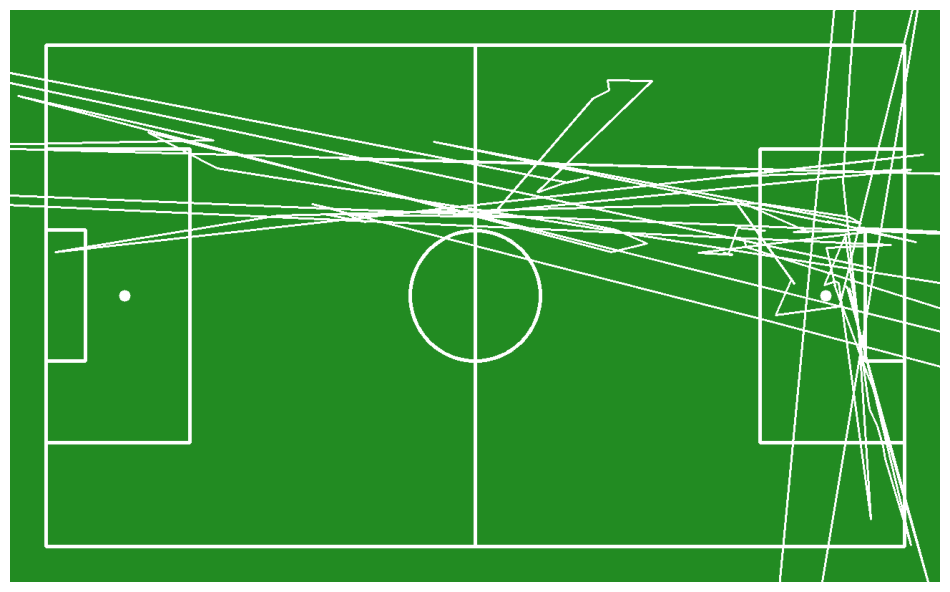

In [119]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [120]:
from typing import List, Union

def replace_outliers_based_on_distance(
    positions: List[np.ndarray],
    distance_threshold: float
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            # If the current position is already empty, just add it to the cleaned positions
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                # If there's no valid last position, accept the first valid one
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                # Calculate the distance from the last valid position
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    # Replace with empty array if the distance exceeds the threshold
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position

    return cleaned_positions

In [122]:
MAX_DISTANCE_THRESHOLD = 500

path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THRESHOLD)

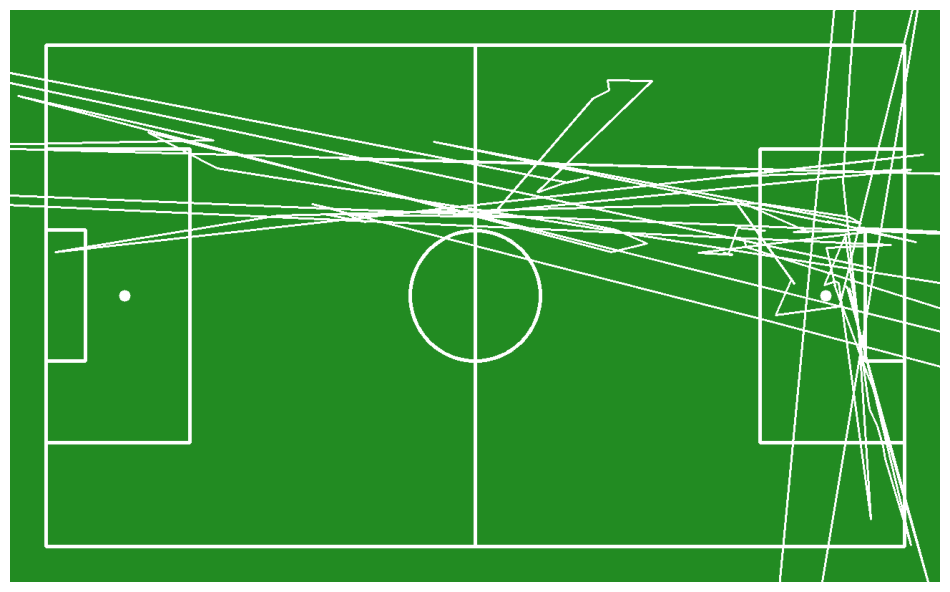

In [121]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# Model Finetuning


In [123]:
! pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
from ultralytics import YOLO

# Load the pre-trained model
model = YOLO("/content/drive/MyDrive/TestTesi/video/football-players-detection.pt")


from roboflow import Roboflow
rf = Roboflow(api_key="BcCi5HI587O02q1v831w")
project = rf.workspace("margherita-3vose").project("football-players-detection-3zvbc-vrohf")
version = project.version(3)
dataset = version.download("yolov8")

!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml


# Fine-tune the model
model.train(
    data="/content/football-players-detection-3/data.yaml",
    epochs=50,
    batch=4,
    imgsz=640,
    lr0=0.001,
    lrf=0.01,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    weight_decay=0.0005,
    freeze=10,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,
    mosaic=1.0,
    close_mosaic=10,
    optimizer="AdamW",
    patience=10,
    cache=False
)

loading Roboflow workspace...
loading Roboflow project...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/football-players-detection-3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/TestTesi/video/football-players-detection.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opse

train: Scanning /content/football-players-detection-3/train/labels.cache... 200 images, 24 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 730.1±338.5 MB/s, size: 21.7 KB)



val: Scanning /content/football-players-detection-3/valid/labels.cache... 32 images, 9 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.925      1.635      1.626          3        640: 100%|██████████| 50/50 [06:48<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:51<00:00, 12.78s/it]

                   all         32        135      0.602      0.277      0.289      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.914      1.393      1.546         12        640: 100%|██████████| 50/50 [06:50<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.46s/it]

                   all         32        135      0.606      0.289       0.33      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.785      1.295      1.485         33        640: 100%|██████████| 50/50 [06:59<00:00,  8.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:36<00:00,  9.22s/it]

                   all         32        135      0.663      0.314      0.337      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.682      1.226      1.459         20        640: 100%|██████████| 50/50 [06:52<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.30s/it]

                   all         32        135      0.678      0.424      0.435      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.607      1.111      1.403         25        640: 100%|██████████| 50/50 [06:36<00:00,  7.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.91s/it]

                   all         32        135      0.385      0.456      0.323      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G       1.63      1.093      1.346         18        640: 100%|██████████| 50/50 [06:53<00:00,  8.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.98s/it]

                   all         32        135      0.596      0.387      0.427      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G       1.65      1.072      1.363         27        640: 100%|██████████| 50/50 [06:47<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:36<00:00,  9.03s/it]

                   all         32        135      0.392      0.435       0.38      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.634       1.11      1.417         10        640: 100%|██████████| 50/50 [06:52<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:51<00:00, 12.79s/it]

                   all         32        135      0.423      0.425      0.411      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.547     0.9457      1.249         26        640: 100%|██████████| 50/50 [06:45<00:00,  8.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:36<00:00,  9.08s/it]

                   all         32        135       0.57      0.486      0.405      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.541     0.9937      1.302         29        640: 100%|██████████| 50/50 [06:42<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:36<00:00,  9.17s/it]

                   all         32        135      0.514      0.557      0.445      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.531     0.9619       1.32         43        640: 100%|██████████| 50/50 [06:45<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.89s/it]

                   all         32        135      0.485      0.567      0.461      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.568      1.236       1.36         12        640:  62%|██████▏   | 31/50 [04:06<02:32,  8.04s/it]